# Module 3 Project - Whisky Sommelier
# Classification Modeling
By: **Maura Cerow**, **Rajeev Panwar** and **Bryan Santos**

This project aims to build the first module of a comprehensive whisky recommendation engine, an **automated whisky sommelier**. We would like this to act as a go-to "middle-man" between distributors, bars and consumers.

This notebook includes initial classification models and their scores. Then we will choose among the models which ones to hypertune or improve further. 

## Our Modeling Process

The business objective our final model will try to address is to be able to complete a comprehensive whisky recommendation engine. Because our dataset is not sensitive unlike health or disease datasets, we are treating recall and precision with equal importance. Hence, we need balance between our Type I and Type II errors.

Our modeling process is unique and follows these steps:
   1. Perform baseline modeling of each of the following methods then different metrics will be tallied. There will be no hyperparameter tuning for this part yet to be explained why below.
    - Logistic Regression
    - K-Nearest Neighbors
    - Decision Trees
    - Random Forest
    - Adaptive Boost
    - Gradient Boost
    - XGBoost
    - Naive Bayes
   2. Because we believe that we have indeed a significant class imbalance, we need to perform resampling. To do this, we then combine all of those methods with each of the following resampling techniques. Metrics will again be recorded.
    - Random Undersampling
    - Random Oversampling
    - Tomek Links
    - Cluster Centroids
    - SMOTE
    - SMOTE Tomek Links
   3. After getting the scores of all of those combinations, we will select the top five (5) models for further improvement and hyperparameter tuning, if applicable.
   4. All of the model evaluation, hyperparameter tuning and final selection will be performed in the succeeding notebook.
   5. Please note that there will be no analysis in this notebook as this is purely for summarizing all of the baseline scores of each classification method combined with different resampling techniques.
    
    

## Dataset

Here is the final dataset after webscraping, hypothesis testing, EDA and feature engineering.

**Target**  
- Whisky's country of origin: 
    - Scotland
    - Japan
    - USA
    - Canada
    - Ireland

**Features**
- Type (whether it is Single Malt, Blended, Rye, etc.)
- Price (ranging from 1 to 5 with 5 being the most expensive):
    - 1: < USD25
    - 2: USD25 to USD50
    - 3: USD50 to USD80
    - 4: USD80 to USD150
    - 5 > USD150
Expert Score (critic score):
    - 0-49: Very poor quality
    - 50-59: Poor quality
    - 60-69: Below average
    - 70-79: Average
    - 80-84: Good
    - 85-89: Great
    - 90-95: Very High Quality
    - 96-100: Incredibly High Quality
- User Rating (distiller.com user reviews, from 1 to 5 stars)
- ABV (Alcohol By Volume)
- Description
- Style (ingredients)
- Maturing/Cask (whether matured in oak, sherry, etc.)
- Flavor Profiles (each having intensity scores ranging from 0 to 100):
    - *Smoky*
    - *Peaty*
    - *Spicy*
    - *Herbal*
    - *Oily*
    - *Full-Bodied*
    - *Rich*
    - *Sweet*
    - *Briny*
    - *Salty*
    - *Vanilla*
    - *Tart*
    - *Fruity*
    - *Floral* 
- Big-ticket items (classification of expensive varieties)
- Reputation (tagging of whether people love it or those with poor expert reviews)
- Bang-for-the-buck (expert score per price and user rating per price)
- Flavor intensity (whether intense or subtle)

## Package Imports and Data Load

In [1]:
### Needed libraries for Classification Modeling ###

### Basic packages ###
import numpy as np
import pandas as pd 

### Modeling ###
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
import itertools
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve
import imblearn
from sklearn.preprocessing import LabelBinarizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score



sns.set()

%matplotlib inline

### Suppress notebook warnings ###
import warnings
warnings.filterwarnings('ignore')

### Pandas settings to avoid exponential form and display all columns ###
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

/Users/Bryan/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
df = pd.read_csv("whiskey_feat_engineered.csv")

Prepare dataframe that would summarize all the metrics from the models.

In [3]:
global summary_df
summary_df = pd.DataFrame(columns=['Model', 'Imbalance Handling','Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC Score'])
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score


## Functions for Reuse

These are all the functions for reuse separated into corresponding Data Science process. This makes for faster modeling and cleaner code.

### Data Pre-Processing

### Train Test Split

In [4]:
def data_split(features, target):
    '''
    This function splits the dataset into training and testing.
    
    Parameter: 
        Features: independent variables
        Target: dependent variable        
          
    Returns: 
        This returns the dataset split into four categories: features training and testing,
        target training and testing.
    
    '''
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42,test_size=0.2)
    return {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

### Scaling

In [5]:
def scaler(features_train, features_test):

    '''
    This function scales/standardizes the features data with values 0 to 1. The resulting
    columns are best used when comparing weights.
    
    Parameter: 
        features_train: independent variables for training
        features_test: independent variables for testing       
          
    Returns: 
        This returns the standardized features.
    
    '''
    
    scaler = StandardScaler()  
    scaler.fit(features_train)
        
    X_train_scaled = scaler.transform(features_train)  
    X_test_scaled = scaler.transform(features_test)  
    
    return {'X_train_scaled': X_train_scaled, 'X_test_scaled': X_test_scaled}

### Clasification Methods

#### Logistic Regression

In [6]:
def logistic_regression(features, target):
    '''
    This function runs logistic regression and outputs the model used for fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
          
    Returns: 
        This returns the logistic regression model.
    '''
    logistic_regression_model = LogisticRegression().fit(features, target)
    return logistic_regression_model

#### K-Nearest Neighbors

In [7]:
def knn(features, target, n):
    '''
    This function runs k-nearest neighbor method and outputs the model used for fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
        n: number of neighbors parameter
    Returns: 
        This returns the knn model.
    '''
    knn_model = KNeighborsClassifier(n_neighbors=n)
    knn_model = knn_model.fit(features, target)
    return knn_model

In [8]:
def knn_best_model(features_train, target_train, features_test, target_test):
    '''
    This function runs k-nearest neighbor models and checks the best n_neighbors variable.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
          
    Returns: 
        This returns a comparison of knn results with different number of neighbors as
        parameter.
    '''
    k_range = list(range(1, 11))
    k_scores = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(features_train, target_train)
        y_predict = knn.predict(features_test)
        score = f1_score(target_test, y_predict, average='weighted')
        k_scores.append(score)
        print("n = " + str(k) + " - " + str(score))
        
    plt.figure(figsize=(12, 6))  
    plt.plot(range(1, 11), k_scores, color='red', linestyle='dashed', marker='o',  
             markerfacecolor='blue', markersize=10)
    plt.title('F1 score by K Value')  
    plt.xlabel('K Value')  
    plt.ylabel('F1 Score') 
    plt.show()

#### Decision Trees

In [9]:
def decision_tree(features, target, depth):
    '''
    This function runs decision tree algorithm method and outputs the model used for 
    fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
        depth: maximum depth parameter
    Returns: 
        This returns the decision tree model.
    '''
    decision_tree_model = DecisionTreeClassifier(max_depth = depth)
    decision_tree_model.fit(features, target)    
    
    dot_data = StringIO()
    export_graphviz(decision_tree_model, out_file=dot_data,  
                    rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    Image(graph.create_png())
    return decision_tree_model

In [10]:
def decision_tree_best_model(features, target):
    '''
    This function runs decision tree models models and checks the best depth parameter.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
          
    Returns: 
        This returns a comparison of decision tree results with different depths as
        parameter.
    '''
    depth_range = range(1,10)
    val = []
    for depth in depth_range:
        ctree = DecisionTreeClassifier(max_depth = depth)
        depth_score = cross_val_score(ctree, features, target, cv = 10)
        val.append(depth_score.mean())
        print(str(depth_range) + " - " + str(depth_score.mean()))
    plt.figure(figsize = (10,10))
    plt.plot(depth_range, val)
    plt.xlabel('range of depth')
    plt.ylabel('cross validated values')
    plt.show()

#### Random Forest

In [11]:
def random_forest(features, target, params, baseline):
    '''
    This function runs random forest algorithm method and outputs the model used for 
    fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
        params: parameters after hypertuning
        baseline: set to True if to run initial, baseline model
    Returns: 
        This returns the random forest model.
    '''
    if (params == None) & (baseline == True):
        random_forest_model = RandomForestClassifier(random_state = 42)
        random_forest_model.fit(features, target)
        print(random_forest_model.get_params())
        return random_forest_model
    else:
        random_forest_model = RandomForestClassifier(**params, random_state = 42)
        random_forest_model.fit(features, target)
        return random_forest_model

#### Adaptive Boosting

In [12]:
def adaboost(features, target, params, baseline):
    '''
    This function runs adaptive boosting ensemble method and outputs the model used for 
    fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
        params: parameters after hypertuning
        baseline: set to True if to run initial, baseline model
    Returns: 
        This returns the adaptive boosting model.
    '''
    if (params == None) & (baseline == True):
        adaboost_model = AdaBoostClassifier(n_estimators=100, base_estimator= None,learning_rate=1, random_state = 42)
        adaboost_model.fit(features, target)
        print(adaboost_model)
        return adaboost_model
    else:
        adaboost_model = AdaBoostClassifier(**params)
        adaboost_model.fit(features, target)
        return adaboost_model

#### Gradient Boosting

In [13]:
def gradientboost(features, target, params, baseline):
    '''
    This function runs gradient boosting ensemble method and outputs the model used for 
    fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
        params: parameters after hypertuning
        baseline: set to True if to run initial, baseline model
    Returns: 
        This returns the gradient boosting model.
    '''
    if (params == None) & (baseline == True):
        params_baseline = {
        'n_estimators': 1,
        'max_depth': 1,
        'learning_rate': 1,
        'criterion': 'mse',
        'random_state': 42
        }

        gradient_boost_model = GradientBoostingClassifier(**params_baseline)
        gradient_boost_model.fit(features, target)
        return gradient_boost_model

    else:
        gradient_boost_model = GradientBoostingClassifier(**params, random_state = 42)
        gradient_boost_model.fit(features, target)
        return gradient_boost_model

#### Extreme Gradient Boosting (XGBoost)

In [14]:
def xgboost(features, target, params, baseline):
    '''
    This function runs xgboosting ensemble method and outputs the model used for 
    fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       
        params: parameters after hypertuning
        baseline: set to True if to run initial, baseline model
    Returns: 
        This returns the xgboosting model.
    '''
    if (params == None) & (baseline == True):
        xgboost_model = XGBClassifier(n_jobs = -1)
        xgboost_model.fit(features, target)
        print(xgboost_model)
        return xgboost_model
    else:
        xgboost_model = XGBClassifier(**params)
        xgboost_model.fit(features, target)
        return xgboost_model

#### Naive Bayes

In [15]:
def naive_bayes(features, target):
    '''
    This function runs naive bayes method and outputs the model used for 
    fitting later.
    
    Parameter: 
        features: independent variables for training
        target: dependent variable for training       

    Returns: 
        This returns the naive bayes model.
    '''
    naive_bayes_model = GaussianNB()
    naive_bayes_model.fit(features, target)
    return naive_bayes_model

### Scoring and Evaluation

#### Grid Search Cross Validation

In [16]:
def grid_search_cv(model, features, target, params, n_jobs, cv):
    '''
    This function automatically runs grid search cross validation for hyperparameter tuning
    and determining the set of parameters that would produce the best results.
    
    Parameter: 
        model: model to be used for fitting
        features: independent variables
        target: dependent variable       
        params: parameters after hypertuning
        n_jobs: number of parallel jobs to run
        cv: number of cross-validation folds
        
    Returns: 
        This returns the best parameters.
    '''
    grid_search = GridSearchCV(estimator = model, param_grid = params, 
                          n_jobs=n_jobs, cv = cv)
    grid_search.fit(features, target)
    return grid_search.best_params_

#### Standard Scores

In [17]:
def score_model(model, handling, features_train, target_train, features_test, target_test):
    '''
    This function automatically runs the model inputted and calculates the following
    metrics: accuracy, precision, recall, and F1 score. Then this appends to the summary
    table initialized earlier that would list all results of all models run. This is for
    easier comparison and model evaluation. Finally, this also outputs the corresponding
    confusion matrix of the model.
    
    Parameter: 
        model: model to be used for fitting
        features_train: independent variables for training
        target_train: dependent variable for training      
        features_train: independent variables for testing
        target_train: dependent variable for testing  
        
    Returns: 
        This returns all the pertinent metrics, confusion matrix and appends to the summary
        dataframe.
    '''
    predictions = model.predict(features_test)
    accuracy = metrics.accuracy_score(target_test, predictions)
    precision = metrics.precision_score(target_test, predictions, average='weighted')
    recall = metrics.recall_score(target_test, predictions, average='weighted')
    f1 = metrics.f1_score(target_test, predictions, average='weighted')
    y_pred_prob = model.predict_proba(features_test)[:, 1]
    
    lb = LabelBinarizer()
    lb.fit(target_test)
    y_test = lb.transform(target_test)
    
    y_pred = model.predict(features_test)
    y_pred = lb.transform(y_pred)
    #return roc_auc_score(y_test, y_pred, average=average)
    
    roc_auc = metrics.roc_auc_score(y_test, y_pred, average="weighted")
    #cv = cross_val_score(model, features, target, cv=10, scoring='roc_auc').mean()
        
    cm = confusion_matrix(target_test, predictions)
    classes = ['Scotch', 'American', 'Canadian', 'Irish', 'Japanese']
    
    plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
    global summary_df
    summary_df = summary_df.append({'Model': str(model).split('(')[0], 'Imbalance Handling' : handling , 'Accuracy' : accuracy, 'Precision' : precision, 'Recall': recall,  'F1 Score': f1, 'ROC AUC Score' : roc_auc} , ignore_index=True)

#### Feature Importance

In [18]:
def feature_importance(model, X, y):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

#### Confusion Matrix

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    '''
    This function automatically plots the confusion matrix.
    
    Parameter: 
        cm: confusion matrix from the scoring function
        normalize: True if to be normalized
        title: title of the confusion matrix
        cmap: plotting method
        
    Returns: 
        This returns a graphical confusion matrix
    '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Handling Class Imbalance

#### Random Undersampling

In [20]:
def random_undersampling(X_train, y_train):
    '''
    This function runs random undersampling to address class imbalance.
    
    Parameter: 
        X_train - independent variables for training
        y_train - dependent variable for training
        
    Returns: 
        This returns an updated dataset with random undersampling implemented.
    '''
    rus = RandomUnderSampler(random_state = 42)
    X_train, y_train = rus.fit_sample(X_train, y_train)
    return {'X_train': X_train, 'y_train': y_train}

#### Random Oversampling

In [21]:
def random_oversampling(X_train, y_train):
    '''
    This function runs random oversampling to address class imbalance.
    
    Parameter: 
        X_train - independent variables for training
        y_train - dependent variable for training
        
    Returns: 
        This returns an updated dataset with random oversampling implemented.
    '''
    ros = RandomOverSampler(random_state = 42)
    X_train, y_train = ros.fit_sample(X_train, y_train)
    return {'X_train': X_train, 'y_train': y_train}

#### Tomek Links

In [22]:
def tomek_links(X_train, y_train):
    '''
    This function runs tomek link undersampling to address class imbalance.
    
    Parameter: 
        X_train - independent variables for training
        y_train - dependent variable for training
        
    Returns: 
        This returns an updated dataset with tomek link undersampling implemented.
    '''
    tl = TomekLinks()
    X_train, y_train = tl.fit_sample(X_train, y_train)
    return {'X_train': X_train, 'y_train': y_train}

#### Cluster Centroids

In [23]:
def cluster_centroids(X_train, y_train):
    '''
    This function runs cluster centroids to address class imbalance.
    
    Parameter: 
        X_train - independent variables for training
        y_train - dependent variable for training
        
    Returns: 
        This returns an updated dataset with cluster centroids implemented.
    '''
    cc = ClusterCentroids(random_state = 42)
    X_train, y_train = cc.fit_sample(X_train, y_train)
    return {'X_train': X_train, 'y_train': y_train}

#### SMOTE

In [24]:
def smote(X_train, y_train):
    '''
    This function runs SMOTE to address class imbalance.
    
    Parameter: 
        X_train - independent variables for training
        y_train - dependent variable for training
        
    Returns: 
        This returns an updated dataset with SMOTE implemented.
    '''
    smote = SMOTE(random_state = 42)
    X_train, y_train = smote.fit_sample(X_train, y_train)
    return {'X_train': X_train, 'y_train': y_train}

#### SMOTETomek

In [25]:
def smote_tomek(X_train, y_train):
    '''
    This function runs a combination of SMOTE and tomek link to address class imbalance.
    
    Parameter: 
        X_train - independent variables for training
        y_train - dependent variable for training
        
    Returns: 
        This returns an updated dataset with SMOTE and tomek link implemented.
    '''
    smt = SMOTETomek(random_state = 42)
    X_train, y_train = smt.fit_sample(X_train, y_train)
    return {'X_train': X_train, 'y_train': y_train}

## Feature Selection

This is where the target and features are to be declared because all the modelling will happen automatically. 

In [26]:
df.columns

Index(['Unnamed: 0', 'name', 'type', 'price', 'expert_score', 'user_rating',
       'description', 'abv', 'style', 'cask', 'review', 'smoky', 'peaty',
       'spicy', 'herbal', 'oily', 'full-bodied', 'rich', 'sweet', 'briny',
       'salty', 'vanilla', 'tart', 'fruity', 'floral', 'country',
       'countries_cat', 'cask_category', 'cask_cat_num', 'type_num',
       'big_ticket', 'poor_performer', 'people_love_this', 'escore_per_price',
       'urating_per_price', 'flavor_intensity'],
      dtype='object')

Set independent variables with dummy data through One Hot Encoding

In [27]:
dummies = pd.get_dummies(df['cask_category'], drop_first=True)
df = pd.concat([df, dummies], axis = 1)
dummies = pd.get_dummies(df['type'], drop_first=True)
df = pd.concat([df, dummies], axis = 1)

In [28]:
df.columns

Index(['Unnamed: 0', 'name', 'type', 'price', 'expert_score', 'user_rating',
       'description', 'abv', 'style', 'cask', 'review', 'smoky', 'peaty',
       'spicy', 'herbal', 'oily', 'full-bodied', 'rich', 'sweet', 'briny',
       'salty', 'vanilla', 'tart', 'fruity', 'floral', 'country',
       'countries_cat', 'cask_category', 'cask_cat_num', 'type_num',
       'big_ticket', 'poor_performer', 'people_love_this', 'escore_per_price',
       'urating_per_price', 'flavor_intensity', 'bourbon_oak',
       'bourbon_sherry', 'new', 'oak', 'other', 'sherry', 'sherry_oak', 'used',
       'wine', 'Bourbon', 'Canadian', 'Flavored Whiskey', 'Grain Whiskey',
       'Grain Whisky', 'Other Whiskey', 'Rye', 'Single Malt',
       'Single Pot Still', 'Tennessee', 'White'],
      dtype='object')

Set dependent variable

In [29]:
target = df['country']

Set independent variables

In [30]:
features_rf = df[['smoky', 'peaty', 'spicy', 'herbal', 'oily', 'full-bodied', 'rich', 'sweet', 
               'briny', 'salty', 'vanilla', 'tart', 'fruity', 'floral', 'type_num', 'price',
               'expert_score', 'user_rating', 'abv', 'cask_cat_num', 'big_ticket',  
               'poor_performer', 'people_love_this', 'escore_per_price', 'urating_per_price',
               'flavor_intensity']]

In [31]:
features = df[['price', 'expert_score', 'user_rating','abv', 'smoky', 'peaty',
       'spicy', 'herbal', 'oily', 'full-bodied', 'rich', 'sweet', 'briny', 'salty', 
       'vanilla', 'tart', 'fruity', 'floral', 'big_ticket', 'poor_performer',
       'people_love_this', 'escore_per_price', 'urating_per_price',
       'flavor_intensity', 'bourbon_oak', 'bourbon_sherry', 'new', 'oak',
       'other', 'sherry', 'sherry_oak', 'used', 'wine', 'Bourbon', 'Canadian',
       'Flavored Whiskey', 'Grain Whiskey', 'Grain Whisky', 'Other Whiskey',
       'Rye', 'Single Malt', 'Single Pot Still', 'Tennessee', 'White']]

In [32]:
df.shape

(2662, 56)

Train test split of the dataset as best practice prior to modeling.

In [33]:
split = data_split(features,target)
split_rf = data_split(features_rf, target)

## Model Fitting and Hyperparameter Tuning (without class imbalance handling)

### Logistic Regression

In [34]:
logistic_regression_model = logistic_regression(split['X_train'], split['y_train'])

Confusion Matrix, without normalization
[[165  22   4   2   8]
 [ 16 218   7   0   1]
 [  3   9  18   0   1]
 [ 17  16   1   0   0]
 [ 16   4   1   0   4]]


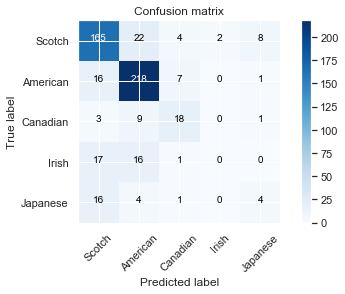

In [35]:
score_model(logistic_regression_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [36]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809


### K-Nearest Neighbor

In [37]:
scaled = scaler(split['X_train'], split['X_test'])

In [38]:
knn_model = knn(scaled['X_train_scaled'], split['y_train'], 1)

Confusion Matrix, without normalization
[[174   4   1  15   7]
 [ 10 226   2   1   3]
 [  1   1  29   0   0]
 [ 12   2   0  16   4]
 [ 14   2   0   2   7]]


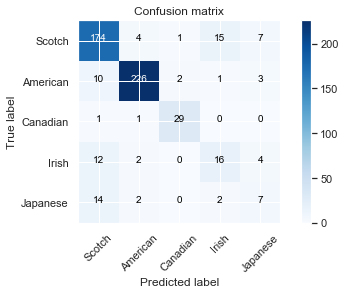

In [39]:
score_model(knn_model, "None", scaled['X_train_scaled'], split['y_train'], scaled['X_test_scaled'], split['y_test'])

In [40]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894


n = 1 - 0.8466072027501808
n = 2 - 0.8527214681257482
n = 3 - 0.8571139111637096
n = 4 - 0.852501098648611
n = 5 - 0.8449900264501766
n = 6 - 0.8312056056366838
n = 7 - 0.8490293290143035
n = 8 - 0.8414921382231326
n = 9 - 0.8402308415180136
n = 10 - 0.8421006470082579


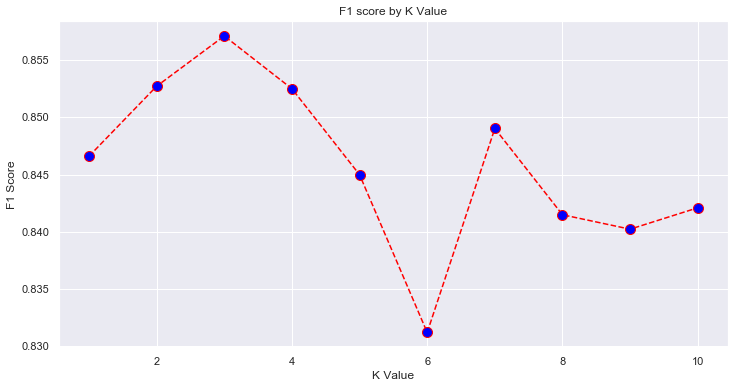

In [41]:
knn_best_model(scaled['X_train_scaled'], split['y_train'], scaled['X_test_scaled'], split['y_test'])

In [42]:
knn_model = knn(scaled['X_train_scaled'], split['y_train'], 4)

Confusion Matrix, without normalization
[[189   3   0   7   2]
 [ 13 227   0   2   0]
 [  1   1  29   0   0]
 [ 14   4   0  14   2]
 [ 20   1   0   1   3]]


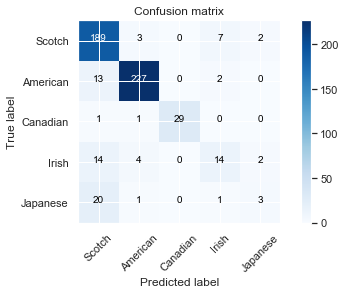

In [43]:
score_model(knn_model, "None", scaled['X_train_scaled'], split['y_train'], scaled['X_test_scaled'], split['y_test'])

In [44]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898


### Decision Tree

In [45]:
decision_tree_model = decision_tree(split['X_train'], split['y_train'], 5)

Confusion Matrix, without normalization
[[164  29   0   1   7]
 [ 22 220   0   0   0]
 [  0   2  29   0   0]
 [ 18  16   0   0   0]
 [ 23   2   0   0   0]]


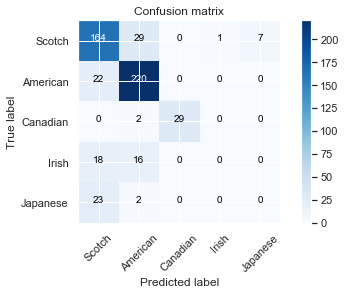

In [46]:
score_model(decision_tree_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [47]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813


range(1, 10) - 0.7313180972628222
range(1, 10) - 0.788154398086633
range(1, 10) - 0.7891066524935778
range(1, 10) - 0.7966206041279121
range(1, 10) - 0.823392240233856
range(1, 10) - 0.8135286562140136
range(1, 10) - 0.8229205421206484
range(1, 10) - 0.824794047302684
range(1, 10) - 0.8163455576224644


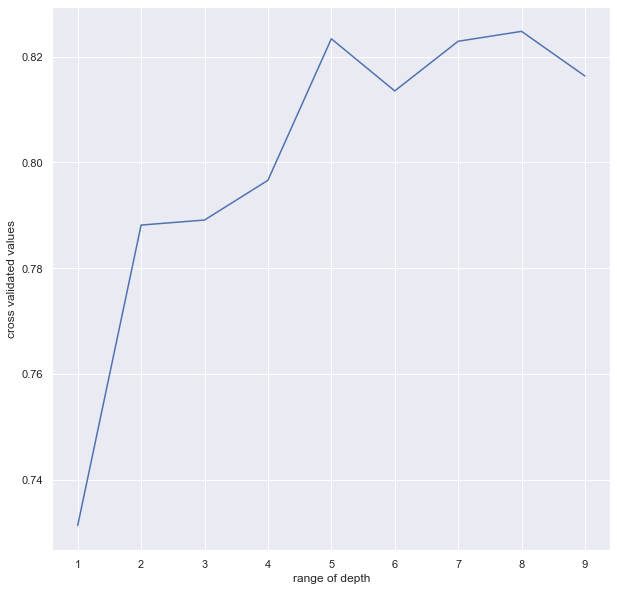

In [48]:
decision_tree_best_model(split['X_train'], split['y_train'])

In [49]:
decision_tree_model = decision_tree(split['X_train'], split['y_train'], 6)

Confusion Matrix, without normalization
[[178  19   0   1   3]
 [ 18 223   0   0   1]
 [  0   2  29   0   0]
 [ 19  15   0   0   0]
 [ 21   4   0   0   0]]


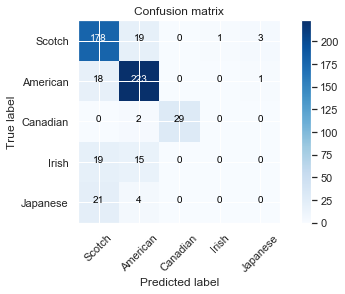

In [50]:
score_model(decision_tree_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [51]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839


### Random Forest

In [52]:
random_forest_model = random_forest(split_rf['X_train'], split_rf['y_train'], None, True)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Confusion Matrix, without normalization
[[190  11   0   0   0]
 [  6 236   0   0   0]
 [  1   4  26   0   0]
 [ 17  10   0   7   0]
 [ 17   2   0   0   6]]


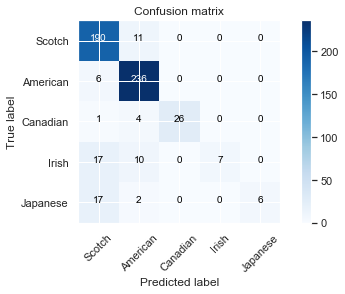

In [53]:
score_model(random_forest_model, "None", split_rf['X_train'], split_rf['y_train'], split_rf['X_test'], split_rf['y_test'])

In [54]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892


In [55]:
n_estimators = [200]
max_features = ['auto']
max_depth =[10]
min_samples_leaf=[1]
min_samples_split=[2]
bootstrap = [True]

# Create the random grid
param_grid = {  'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                'min_samples_split': min_samples_split,
                'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [200], 'max_features': ['auto'], 'max_depth': [10], 'min_samples_leaf': [1], 'min_samples_split': [2], 'bootstrap': [True]}


In [56]:
params = grid_search_cv(random_forest_model, features, target, param_grid, 4, 5)
print (params)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [57]:
random_forest_model = random_forest(split_rf['X_train'], split_rf['y_train'], params, False)

Confusion Matrix, without normalization
[[190  11   0   0   0]
 [  7 235   0   0   0]
 [  0   7  24   0   0]
 [ 18  10   0   6   0]
 [ 19   2   0   0   4]]


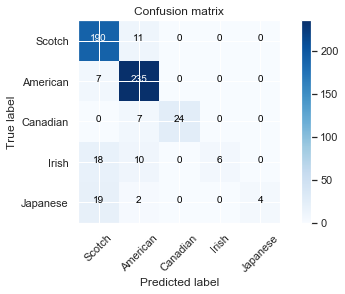

In [58]:
score_model(random_forest_model, "None", split_rf['X_train'], split_rf['y_train'], split_rf['X_test'], split_rf['y_test'])

In [59]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882


### Adaptive Boosting

In [60]:
adaboost_model = adaboost(split['X_train'], split['y_train'], None, True)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=100, random_state=42)


Confusion Matrix, without normalization
[[137   8   0  16  40]
 [ 15 209  11   5   2]
 [  1   2  28   0   0]
 [ 13   5   0  11   5]
 [ 17   1   0   0   7]]


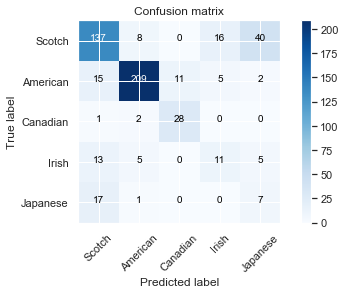

In [61]:
score_model(adaboost_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [62]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825


In [63]:
# n_estimators = [500, 1000, 2000]
# learning_rate = [.001,0.01,.1]
# random_state = [42]

n_estimators = [500]
learning_rate = [.1]
random_state = [42]

param_grid = {  'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'random_state': random_state
             }
print(param_grid)

{'n_estimators': [500], 'learning_rate': [0.1], 'random_state': [42]}


In [64]:
params = grid_search_cv(adaboost_model, features, target, param_grid, 4, 5)
print (params)

{'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 42}


In [65]:
adaboost_model = adaboost(split['X_train'], split['y_train'], params, False)

Confusion Matrix, without normalization
[[194   3   0   3   1]
 [ 20 215   5   2   0]
 [  1   1  29   0   0]
 [ 21   5   0   8   0]
 [ 21   2   0   0   2]]


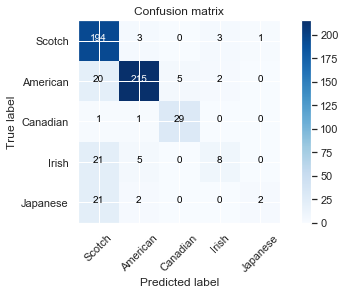

In [66]:
score_model(adaboost_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [67]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875


### Gradient Boost

In [68]:
gradient_boost_model = gradientboost(split['X_train'], split['y_train'], None, True)

Confusion Matrix, without normalization
[[156  39   0   0   6]
 [ 15 227   0   0   0]
 [  1   1  29   0   0]
 [ 11  18   0   5   0]
 [ 10  14   0   0   1]]


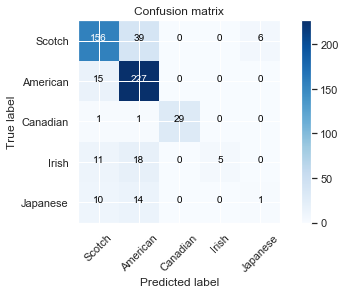

In [69]:
score_model(gradient_boost_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [70]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


In [71]:
param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.1],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_depth":[10],
    "max_features":["auto"],
    "criterion": ["friedman_mse"],
    "subsample":[1.0],
    "n_estimators":[100]
    }

In [72]:
params = grid_search_cv(gradient_boost_model, features, target, param_grid, 4, 5)
print (params)

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}


In [73]:
gradient_boost_model = gradientboost(split['X_train'], split['y_train'], params, False)

Confusion Matrix, without normalization
[[190  10   0   1   0]
 [  9 231   0   1   1]
 [  1   1  29   0   0]
 [ 16   5   0  12   1]
 [ 17   2   0   0   6]]


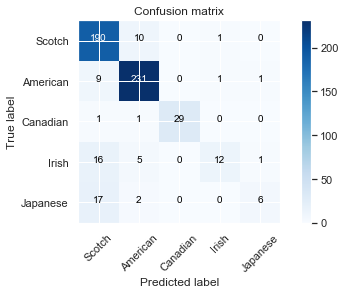

In [74]:
score_model(gradient_boost_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [75]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### XGBoost

In [76]:
xgboost_model = xgboost(split['X_train'], split['y_train'], None, True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Confusion Matrix, without normalization
[[188  10   0   2   1]
 [ 12 229   0   1   0]
 [  1   1  29   0   0]
 [ 18   6   0  10   0]
 [ 17   1   0   0   7]]


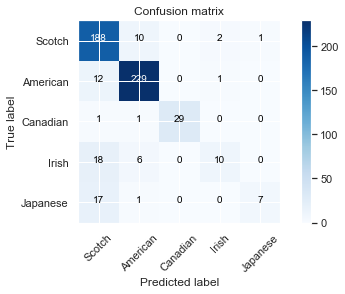

In [77]:
score_model(xgboost_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [78]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


In [79]:
param_grid = {
        'min_child_weight': [10],
        'gamma': [1.5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [5]
        }

In [80]:
params = grid_search_cv(xgboost_model, features, target, param_grid, 4, 5)
print (params)

{'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 1.0}


In [81]:
xgboost_model = xgboost(split['X_train'], split['y_train'], params, False)

Confusion Matrix, without normalization
[[182  13   0   5   1]
 [ 11 227   0   4   0]
 [  1   1  29   0   0]
 [ 19   7   0   8   0]
 [ 17   1   0   0   7]]


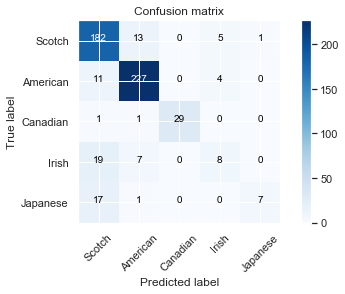

In [82]:
score_model(xgboost_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [83]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### Naive Bayes

In [84]:
naive_bayes_model = naive_bayes(split['X_train'], split['y_train'])

Confusion Matrix, without normalization
[[ 20   0   0  30 151]
 [  0 135  48  19  40]
 [  0   0  30   0   1]
 [  0   0   0  20  14]
 [  1   0   0   1  23]]


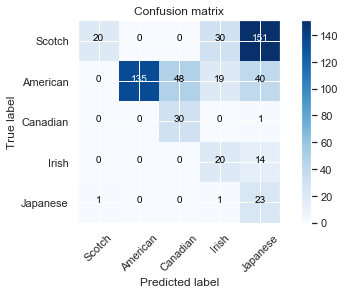

In [85]:
score_model(naive_bayes_model, "None", split['X_train'], split['y_train'], split['X_test'], split['y_test'])

In [86]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


## Model Fitting and Hyperparameter Tuning (with Random Undersampling)

In [87]:
balanced = random_undersampling(split['X_train'], split['y_train'])
balanced_rf = random_undersampling(split_rf['X_train'], split_rf['y_train'])

In [88]:
split_rf['X_train']

,smoky,peaty,spicy,herbal,oily,full-bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,type_num,price,expert_score,user_rating,abv,cask_cat_num,big_ticket,poor_performer,people_love_this,escore_per_price,urating_per_price,flavor_intensity
2130,0,0,10,20,50,40,40,75,15,15,70,60,75,30,0.000,2,82,3.660,46.000,2.000,False,False,False,41.000,41.000,35.714
1882,15,15,65,10,25,40,40,55,0,0,35,45,65,0,0.000,3,84,3.810,46.000,0.000,False,False,False,28.000,28.000,29.286
2066,40,40,50,0,30,40,40,40,0,20,50,10,40,20,1.000,2,83,3.260,50.000,0.000,False,False,False,41.500,41.500,30.000
1614,25,25,30,20,25,35,35,25,15,20,15,5,25,5,2.000,2,85,3.200,46.800,1.000,False,False,False,42.500,42.500,21.786
279,30,30,15,0,15,55,50,60,0,0,50,70,70,10,0.000,5,93,4.580,46.000,2.000,True,False,True,18.600,18.600,32.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,10,10,55,0,25,50,85,20,0,0,30,10,10,0,3.000,3,85,4.030,59.800,0.000,False,False,False,28.333,28.333,21.786
1095,40,40,60,40,40,50,55,50,0,0,30,30,55,25,10.000,3,88,3.920,46.000,3.000,False,False,False,29.333,29.333,36.786
1130,0,0,70,20,10,55,60,90,20,10,50,40,70,70,7.000,2,88,3.040,40.000,5.000,False,False,False,44.000,44.000,40.357
1294,0,0,65,30,40,70,75,50,10,10,50,60,75,50,0.000,5,87,3.768,49.500,4.000,True,False,False,17.400,17.400,41.786


### Logistic Regression

In [89]:
logistic_regression_model = logistic_regression(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[ 89  19  16  30  47]
 [ 18 137  50  23  14]
 [  0   1  24   4   2]
 [  7   2   7  13   5]
 [  4   2   0   2  17]]


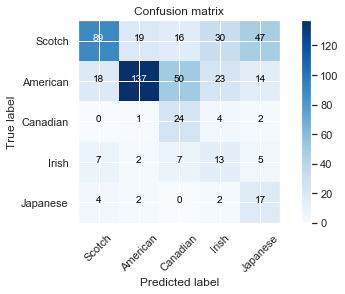

In [90]:
score_model(logistic_regression_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [91]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### K-Nearest Neighbor

In [92]:
scaled = scaler(balanced['X_train'], split['X_test'])

In [93]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[ 88   1   7  55  50]
 [  9 185  17  16  15]
 [  1   0  29   1   0]
 [  9   0   0  19   6]
 [  7   0   1   3  14]]


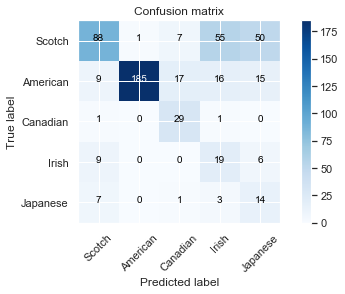

In [94]:
score_model(knn_model, "Random Undersampling", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [95]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


n = 1 - 0.673772414486875
n = 2 - 0.742880504143058
n = 3 - 0.7022449127993229
n = 4 - 0.7064004774121995
n = 5 - 0.7017322295740382
n = 6 - 0.7174135777326818
n = 7 - 0.6894095195814177
n = 8 - 0.701117782961257
n = 9 - 0.7023938711279474
n = 10 - 0.6932911679483573


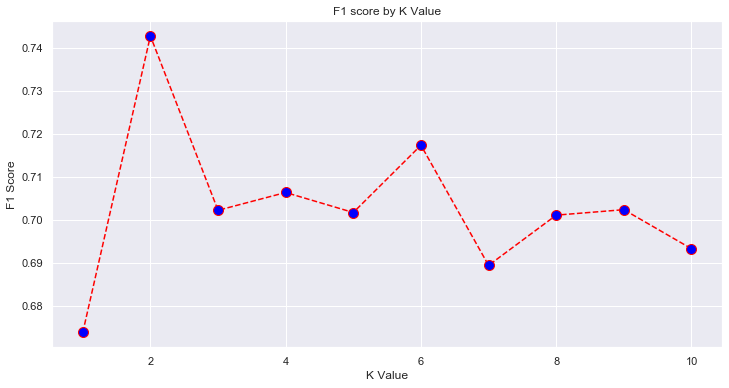

In [96]:
knn_best_model(scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [97]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[ 88   1   7  55  50]
 [  9 185  17  16  15]
 [  1   0  29   1   0]
 [  9   0   0  19   6]
 [  7   0   1   3  14]]


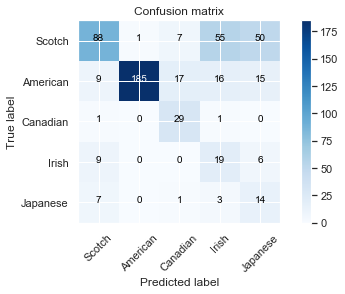

In [98]:
score_model(knn_model, "Random Undersampling", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [99]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### Decision Tree

In [100]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 5)

Confusion Matrix, without normalization
[[ 97   0   0  63  41]
 [ 10 155   0  62  15]
 [  1   1  29   0   0]
 [  7   0   0  20   7]
 [  4   0   0   5  16]]


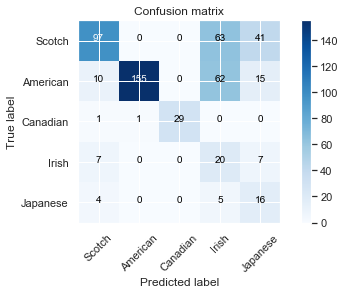

In [101]:
score_model(decision_tree_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [102]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


range(1, 10) - 0.3511627906976744
range(1, 10) - 0.4441860465116279
range(1, 10) - 0.5
range(1, 10) - 0.5837209302325581
range(1, 10) - 0.6488372093023257
range(1, 10) - 0.6651162790697676
range(1, 10) - 0.6767441860465118
range(1, 10) - 0.6465116279069768
range(1, 10) - 0.6604651162790699


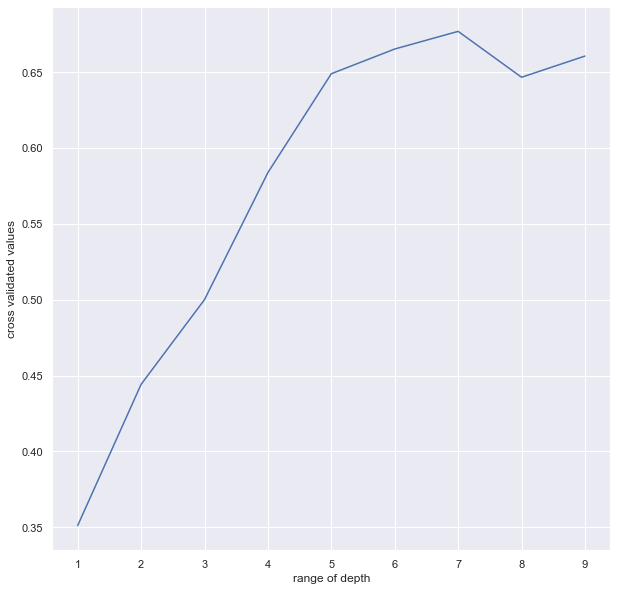

In [103]:
decision_tree_best_model(balanced['X_train'], balanced['y_train'])

In [104]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 6)

Confusion Matrix, without normalization
[[ 87  14   0  63  37]
 [ 13 188  13  16  12]
 [  1   1  29   0   0]
 [  7   5   0  15   7]
 [  6   1   0   2  16]]


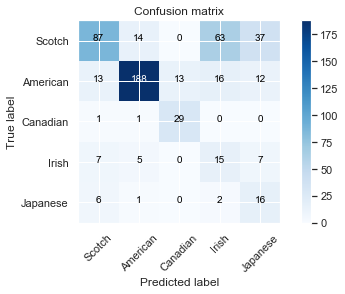

In [105]:
score_model(decision_tree_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [106]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### Random Forest

In [107]:
random_forest_model = random_forest(balanced_rf['X_train'], balanced_rf['y_train'], None, True)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Confusion Matrix, without normalization
[[124   4   1  42  30]
 [ 14 191  22  12   3]
 [  1   0  30   0   0]
 [  9   2   0  22   1]
 [  3   2   0   2  18]]


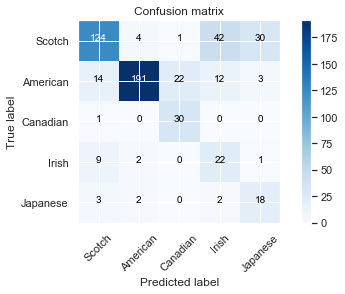

In [108]:
score_model(random_forest_model, "Random Undersampling", balanced_rf['X_train'], balanced_rf['y_train'], split_rf['X_test'], split_rf['y_test'])

In [109]:
balanced_rf['X_train']

,smoky,peaty,spicy,herbal,oily,full-bodied,rich,sweet,briny,salty,vanilla,tart,fruity,floral,type_num,price,expert_score,user_rating,abv,cask_cat_num,big_ticket,poor_performer,people_love_this,escore_per_price,urating_per_price,flavor_intensity
0,45,45,15,0,65,60,10,80,0,0,75,45,70,65,0.000,4,84,3.500,46.000,2.000,True,False,False,21.000,21.000,41.071
1,60,60,5,5,20,10,25,20,10,20,20,0,20,0,0.000,4,80,3.880,50.000,2.000,True,False,False,20.000,20.000,19.643
2,0,0,10,0,10,80,80,80,0,5,20,0,15,10,0.000,2,88,3.650,43.000,1.000,False,False,False,44.000,44.000,22.143
3,10,10,30,20,40,40,40,20,0,5,20,25,30,10,0.000,4,89,3.750,50.000,5.000,True,False,False,22.250,22.250,21.429
4,20,20,40,35,70,65,70,55,15,10,55,10,15,10,0.000,5,87,3.000,57.500,4.000,True,False,False,17.400,17.400,35.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,70,70,50,45,60,57,62,30,25,35,20,15,75,59,0.000,5,95,4.650,43.000,4.000,True,False,True,19.000,19.000,48.071
426,20,20,60,30,20,70,70,65,0,0,60,40,60,10,6.000,3,89,4.020,45.000,1.000,False,False,False,29.667,29.667,37.500
427,0,0,70,0,30,40,50,40,20,20,50,0,60,10,2.000,2,84,3.190,40.000,0.000,False,False,False,42.000,42.000,27.857
428,10,10,20,60,0,40,20,50,0,0,30,10,50,70,2.000,3,87,3.900,43.000,0.000,False,False,False,29.000,29.000,26.429


In [110]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


In [111]:
# n_estimators = [10, 50, 100, 150, 200]
# max_features = ['auto', 'sqrt','log2', 14]
# max_depth =[2,5,7,10]
# min_samples_leaf=[1]
# min_samples_split=[2]
# bootstrap = [True, False]

n_estimators = [200]
max_features = ['auto']
max_depth =[10]
min_samples_leaf=[1]
min_samples_split=[2]
bootstrap = [True]

# Create the random grid
param_grid = {  'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                'min_samples_split': min_samples_split,
                'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [200], 'max_features': ['auto'], 'max_depth': [10], 'min_samples_leaf': [1], 'min_samples_split': [2], 'bootstrap': [True]}


In [112]:
params = grid_search_cv(random_forest_model, features, target, param_grid, 4, 5)
print (params)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [113]:
random_forest_model = random_forest(balanced_rf['X_train'], balanced_rf['y_train'], params, False)

Confusion Matrix, without normalization
[[122   5   2  40  32]
 [  9 190  23  13   7]
 [  1   0  30   0   0]
 [ 10   2   0  21   1]
 [  2   2   0   1  20]]


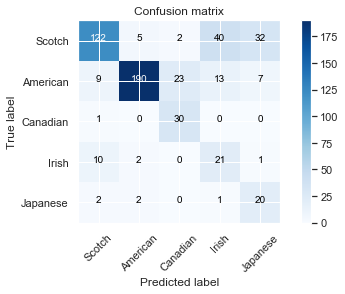

In [114]:
score_model(random_forest_model, "Random Undersampling", balanced_rf['X_train'], balanced_rf['y_train'], split_rf['X_test'], split_rf['y_test'])

In [115]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### Adaptive Boosting

In [116]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], None, True)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=100, random_state=42)


Confusion Matrix, without normalization
[[ 92  13   0  50  46]
 [ 18 171  20  19  14]
 [  1   0  30   0   0]
 [ 11   3   0  12   8]
 [  8   1   0   3  13]]


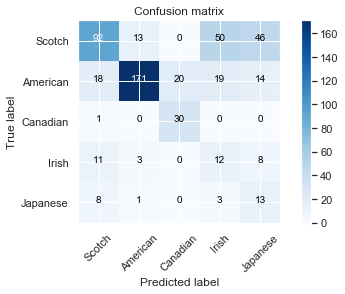

In [117]:
score_model(adaboost_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [118]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


In [119]:
# n_estimators = [500, 1000, 2000]
# learning_rate = [.001,0.01,.1]
# random_state = [42]

n_estimators = [500]
learning_rate = [.1]
random_state = [42]

param_grid = {  'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'random_state': random_state
             }
print(param_grid)

{'n_estimators': [500], 'learning_rate': [0.1], 'random_state': [42]}


In [120]:
params = grid_search_cv(adaboost_model, features, target, param_grid, 4, 5)
print (params)

{'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 42}


In [121]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[ 91   6   0  42  62]
 [ 26 173   2  26  15]
 [  0   1  29   1   0]
 [ 11   1   0  17   5]
 [  5   1   1   5  13]]


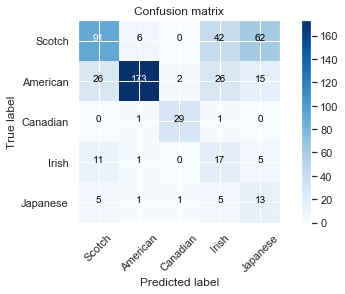

In [122]:
score_model(adaboost_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [123]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### Gradient Boost

In [124]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], None, True)

Confusion Matrix, without normalization
[[115   0   0  29  57]
 [ 12 112   0 111   7]
 [  1   0  29   1   0]
 [  9   0   0  21   4]
 [  6   0   0  11   8]]


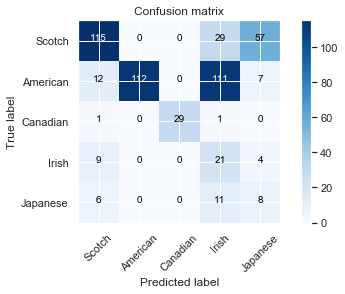

In [125]:
score_model(gradient_boost_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [126]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


In [127]:
# param_grid = {
#     "loss":["deviance", "exponential"],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "min_samples_split": [2],
#     "min_samples_leaf": [1],
#     "max_depth":[3,5,10],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[1.0],
#     "n_estimators":[50, 100, 200]
#     }

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.1],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_depth":[10],
    "max_features":["auto"],
    "criterion": ["friedman_mse"],
    "subsample":[1.0],
    "n_estimators":[100]
    }


# print(param_grid)

In [128]:
params = grid_search_cv(gradient_boost_model, features, target, param_grid, 4, 5)
print (params)

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}


In [129]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[102   5   2  48  44]
 [ 20 176  20  20   6]
 [  1   0  30   0   0]
 [  7   1   0  25   1]
 [  5   1   0   3  16]]


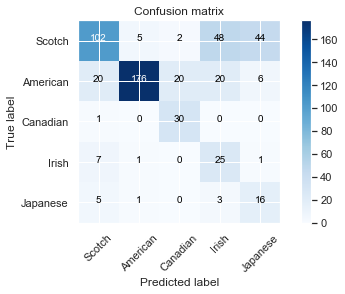

In [130]:
score_model(gradient_boost_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [131]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### XGBoost

In [132]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], None, True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Confusion Matrix, without normalization
[[116   3   1  40  41]
 [ 14 185   9  27   7]
 [  1   0  30   0   0]
 [  6   2   1  24   1]
 [  2   1   0   1  21]]


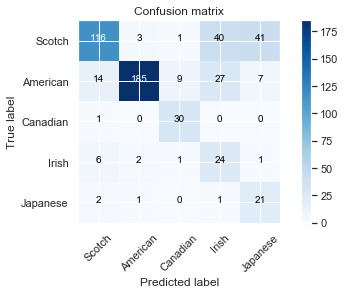

In [133]:
score_model(xgboost_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [134]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


In [135]:
# param_grid = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

param_grid = {
        'min_child_weight': [10],
        'gamma': [1.5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [5]
        }

# print(param_grid)

In [136]:
params = grid_search_cv(xgboost_model, features, target, param_grid, 4, 5)
print (params)

{'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 1.0}


In [137]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[120   4   0  31  46]
 [ 14 188   4  30   6]
 [  1   1  29   0   0]
 [  8   2   0  20   4]
 [  3   1   0   1  20]]


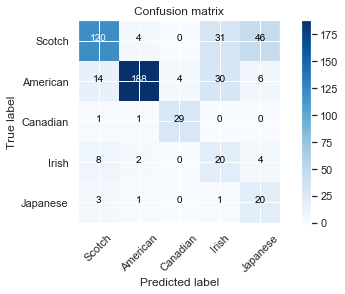

In [138]:
score_model(xgboost_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [139]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### Naive Bayes

In [140]:
naive_bayes_model = naive_bayes(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[ 12   0   0 116  73]
 [  0 156  38  27  21]
 [  0   0  30   1   0]
 [  0   0   0  29   5]
 [  1   0   0  11  13]]


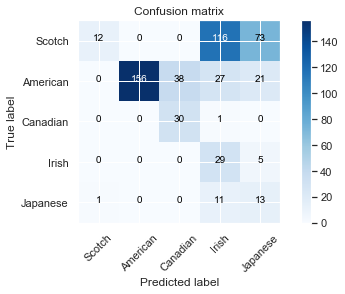

In [141]:
score_model(naive_bayes_model, "Random Undersampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [142]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


## Model Fitting and Hyperparameter Tuning (with Random Oversampling)

In [143]:
balanced = random_oversampling(split['X_train'], split['y_train'])
balanced_rf = random_oversampling(split_rf['X_train'], split_rf['y_train'])

### Logistic Regression

In [144]:
logistic_regression_model = logistic_regression(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[ 94  18   9  35  45]
 [  9 162  32  24  15]
 [  0   2  23   4   2]
 [  5   3   7  12   7]
 [  7   1   2   1  14]]


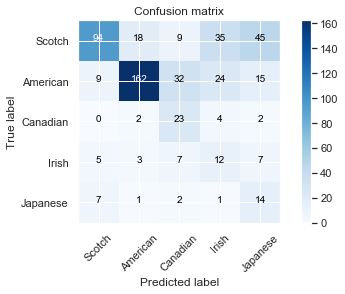

In [145]:
score_model(logistic_regression_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [146]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### K-Nearest Neighbor

In [147]:
scaled = scaler(balanced['X_train'], split['X_test'])

In [148]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[173   6   1  14   7]
 [  9 227   2   1   3]
 [  1   1  29   0   0]
 [ 13   2   0  16   3]
 [ 15   2   0   2   6]]


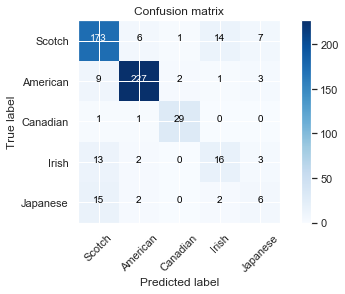

In [149]:
score_model(knn_model, "Random Oversampling", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [150]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


n = 1 - 0.8429442924361475
n = 2 - 0.8439973694692043
n = 3 - 0.8139416588266605
n = 4 - 0.816647672950896
n = 5 - 0.7863905183052292
n = 6 - 0.779534121524908
n = 7 - 0.7648939445788207
n = 8 - 0.7662797312840842
n = 9 - 0.7446055325448134
n = 10 - 0.75275253365262


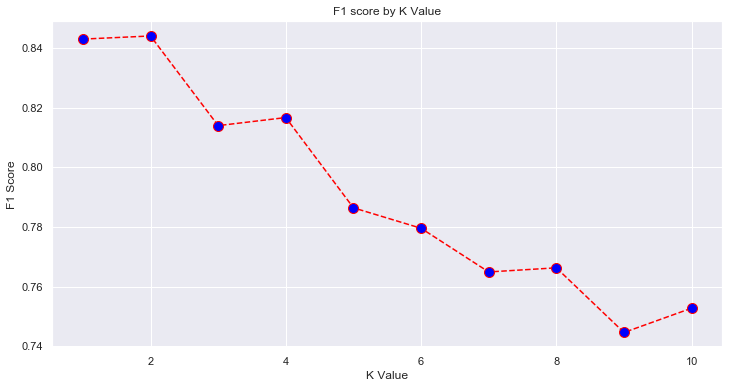

In [151]:
knn_best_model(scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [152]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[173   6   1  14   7]
 [  9 227   2   1   3]
 [  1   1  29   0   0]
 [ 13   2   0  16   3]
 [ 15   2   0   2   6]]


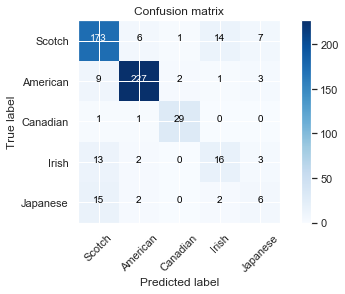

In [153]:
score_model(knn_model, "Random Oversampling", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [154]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### Decision Tree

In [155]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 5)

Confusion Matrix, without normalization
[[ 75   1   0  85  40]
 [  6 172   0  51  13]
 [  0   1  29   1   0]
 [  7   0   0  20   7]
 [  6   0   0   2  17]]


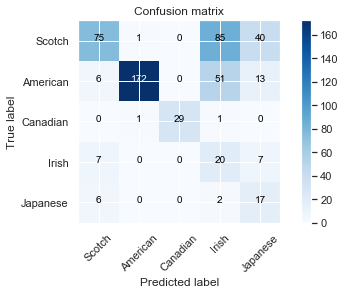

In [156]:
score_model(decision_tree_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [157]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


range(1, 10) - 0.371578947368421
range(1, 10) - 0.46842105263157896
range(1, 10) - 0.5837894736842105
range(1, 10) - 0.6448421052631579
range(1, 10) - 0.6854736842105263
range(1, 10) - 0.7042105263157896
range(1, 10) - 0.7505263157894737
range(1, 10) - 0.7844210526315789
range(1, 10) - 0.8311578947368421


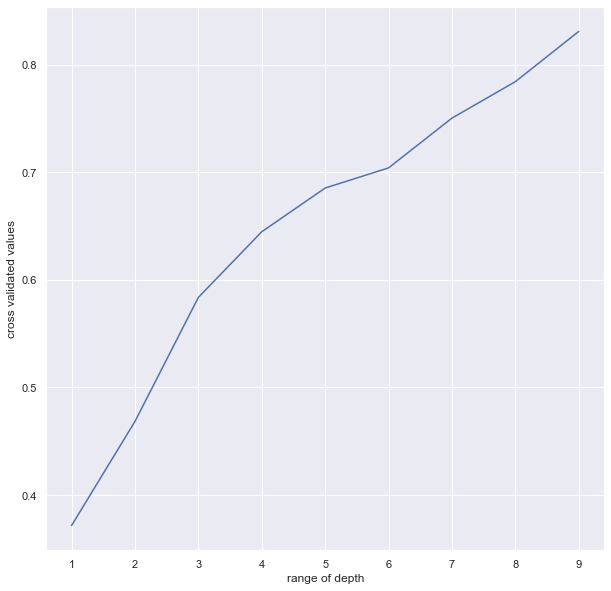

In [158]:
decision_tree_best_model(balanced['X_train'], balanced['y_train'])

In [159]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 6)

Confusion Matrix, without normalization
[[ 79   1   0  85  36]
 [  7 156  16  51  12]
 [  0   1  29   1   0]
 [  7   0   0  20   7]
 [  6   0   0   2  17]]


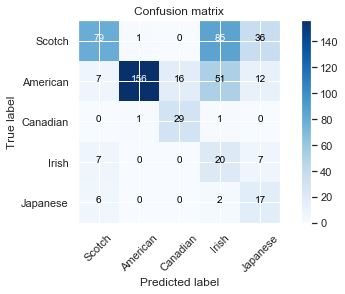

In [160]:
score_model(decision_tree_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [161]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### Random Forest

In [162]:
random_forest_model = random_forest(balanced_rf['X_train'], balanced_rf['y_train'], None, True)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Confusion Matrix, without normalization
[[187  13   0   1   0]
 [  4 237   0   0   1]
 [  0   3  28   0   0]
 [ 16   7   0  11   0]
 [ 14   2   1   0   8]]


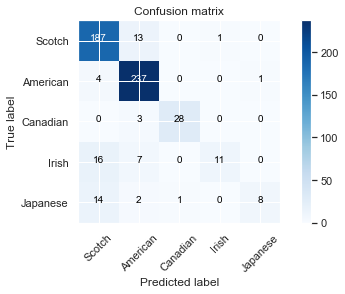

In [163]:
score_model(random_forest_model, "Random Oversampling", balanced_rf['X_train'], balanced_rf['y_train'], split_rf['X_test'], split_rf['y_test'])

In [164]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


In [166]:
# n_estimators = [10, 50, 100, 150, 200]
# max_features = ['auto', 'sqrt','log2', 14]
# max_depth =[2,5,7,10]
# min_samples_leaf=[1]
# min_samples_split=[2]
# bootstrap = [True, False]

n_estimators = [200]
max_features = ['auto']
max_depth =[10]
min_samples_leaf=[1]
min_samples_split=[2]
bootstrap = [True]

# Create the random grid
param_grid = {  'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                'min_samples_split': min_samples_split,
                'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [200], 'max_features': ['auto'], 'max_depth': [10], 'min_samples_leaf': [1], 'min_samples_split': [2], 'bootstrap': [True]}


In [167]:
params = grid_search_cv(random_forest_model, features, target, param_grid, 4, 5)
print (params)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [168]:
random_forest_model = random_forest(balanced_rf['X_train'], balanced_rf['y_train'], params, False)

Confusion Matrix, without normalization
[[184  11   0   6   0]
 [  5 233   1   2   1]
 [  1   1  29   0   0]
 [ 14   6   0  14   0]
 [ 12   3   0   0  10]]


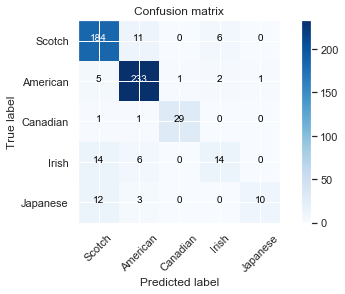

In [169]:
score_model(random_forest_model, "Random Oversampling", balanced_rf['X_train'], balanced_rf['y_train'], split_rf['X_test'], split_rf['y_test'])

In [170]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### Adaptive Boosting

In [171]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], None, True)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=100, random_state=42)


Confusion Matrix, without normalization
[[101   2   0  33  65]
 [ 20 200  12   5   5]
 [  1   0  30   0   0]
 [ 12   1   0   9  12]
 [  4   0   0   6  15]]


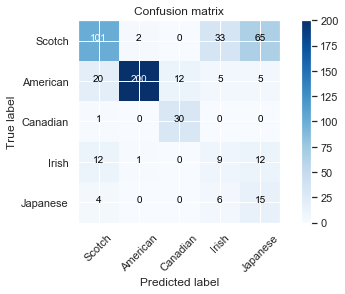

In [172]:
score_model(adaboost_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [173]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


In [174]:
# n_estimators = [500, 1000, 2000]
# learning_rate = [.001,0.01,.1]
# random_state = [42]

n_estimators = [500]
learning_rate = [.1]
random_state = [42]

param_grid = {  'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'random_state': random_state
             }
print(param_grid)

{'n_estimators': [500], 'learning_rate': [0.1], 'random_state': [42]}


In [175]:
params = grid_search_cv(adaboost_model, features, target, param_grid, 4, 5)
print (params)

{'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 42}


In [176]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[135   0   0  36  30]
 [ 15 204   7  14   2]
 [  0   0  30   1   0]
 [ 10   0   0  19   5]
 [  8   1   0   2  14]]


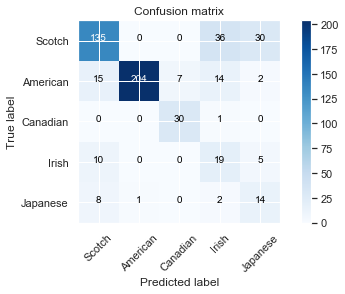

In [177]:
score_model(adaboost_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [178]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### Gradient Boost

In [179]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], None, True)

Confusion Matrix, without normalization
[[156   0   0  24  21]
 [ 15 112   0  90  25]
 [  1   0  29   0   1]
 [ 11   0   0  17   6]
 [ 10   0   0   1  14]]


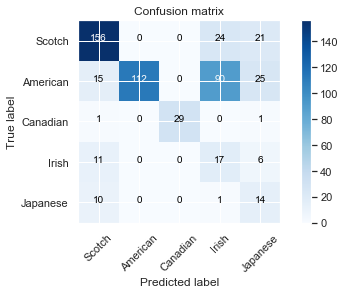

In [180]:
score_model(gradient_boost_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [181]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


In [182]:
# param_grid = {
#     "loss":["deviance", "exponential"],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "min_samples_split": [2],
#     "min_samples_leaf": [1],
#     "max_depth":[3,5,10],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[1.0],
#     "n_estimators":[50, 100, 200]
#     }

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.1],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_depth":[10],
    "max_features":["auto"],
    "criterion": ["friedman_mse"],
    "subsample":[1.0],
    "n_estimators":[100]
    }


# print(param_grid)

In [183]:
params = grid_search_cv(gradient_boost_model, features, target, param_grid, 4, 5)
print (params)

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}


In [184]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[185  11   0   3   2]
 [  7 228   5   2   0]
 [  1   1  29   0   0]
 [ 16   2   0  15   1]
 [ 14   2   0   1   8]]


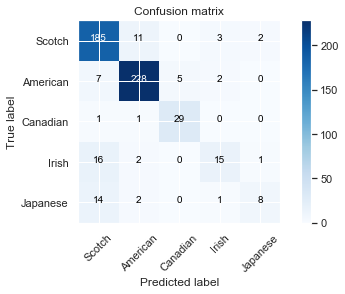

In [185]:
score_model(gradient_boost_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [186]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### XGBoost

In [187]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], None, True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Confusion Matrix, without normalization
[[153   4   0  24  20]
 [ 13 211   4  11   3]
 [  1   1  29   0   0]
 [ 12   1   0  21   0]
 [  7   1   0   0  17]]


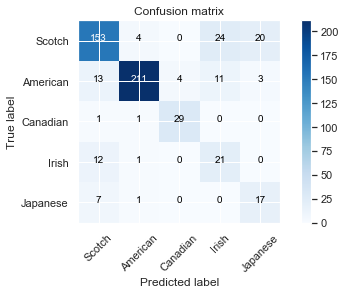

In [188]:
score_model(xgboost_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [189]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


In [190]:
# param_grid = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

param_grid = {
        'min_child_weight': [10],
        'gamma': [1.5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [5]
        }

# print(param_grid)

In [191]:
params = grid_search_cv(xgboost_model, features, target, param_grid, 4, 5)
print (params)

{'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 1.0}


In [192]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[173   5   0  14   9]
 [  7 222   4   8   1]
 [  1   1  29   0   0]
 [ 12   3   0  19   0]
 [ 10   1   0   0  14]]


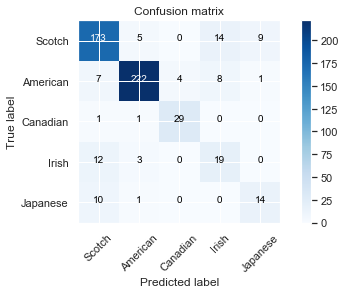

In [193]:
score_model(xgboost_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [194]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### Naive Bayes

In [195]:
naive_bayes_model = naive_bayes(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[ 10   0   0  28 163]
 [  0 131  49  22  40]
 [  0   0  30   0   1]
 [  0   0   0  18  16]
 [  0   0   0   1  24]]


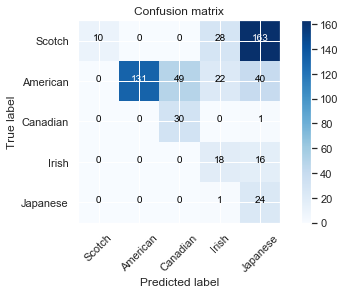

In [196]:
score_model(naive_bayes_model, "Random Oversampling", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [197]:
split = data_split(features,target)

In [198]:
balanced = random_undersampling(split['X_train'], split['y_train'])

## Model Fitting and Hyperparameter Tuning (with Tomek Links)

In [199]:
balanced = tomek_links(split['X_train'], split['y_train'])
balanced_rf = tomek_links(split_rf['X_train'], split_rf['y_train'])

### Logistic Regression

In [200]:
logistic_regression_model = logistic_regression(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[169  24   4   0   4]
 [ 18 221   3   0   0]
 [  4   9  17   0   1]
 [ 18  15   1   0   0]
 [ 18   3   1   0   3]]


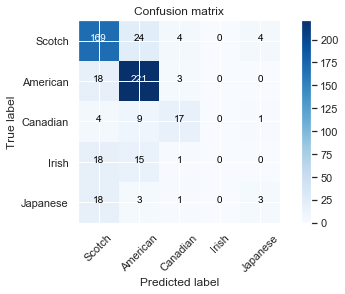

In [201]:
score_model(logistic_regression_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [202]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### K-Nearest Neighbor

In [203]:
scaled = scaler(balanced['X_train'], split['X_test'])

In [204]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[177   7   1   8   8]
 [ 10 226   2   1   3]
 [  1   1  29   0   0]
 [ 11   3   0  15   5]
 [ 13   2   0   3   7]]


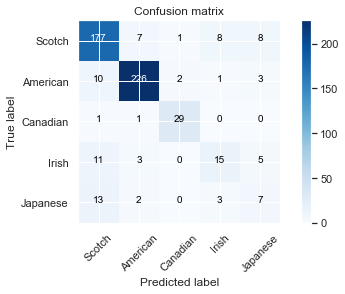

In [205]:
score_model(knn_model, "Tomek Links", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [206]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


n = 1 - 0.8484951939531646
n = 2 - 0.846768801872766
n = 3 - 0.8556245427456775
n = 4 - 0.8451717495608823
n = 5 - 0.8479965433873138
n = 6 - 0.8311135468255066
n = 7 - 0.8478879508998778
n = 8 - 0.838154819200095
n = 9 - 0.8468809782599418
n = 10 - 0.8417965293076329


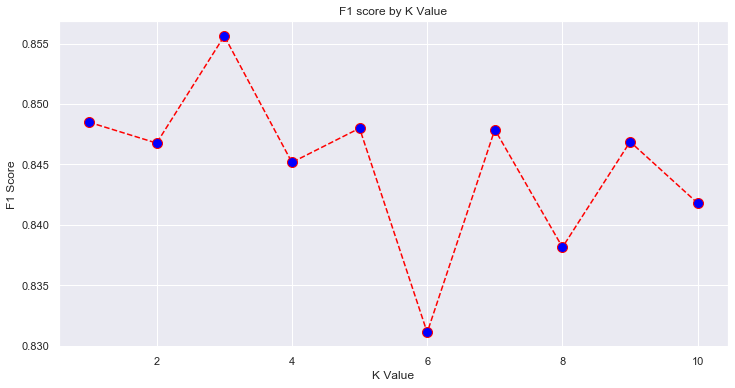

In [207]:
knn_best_model(scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [208]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[177   7   1   8   8]
 [ 10 226   2   1   3]
 [  1   1  29   0   0]
 [ 11   3   0  15   5]
 [ 13   2   0   3   7]]


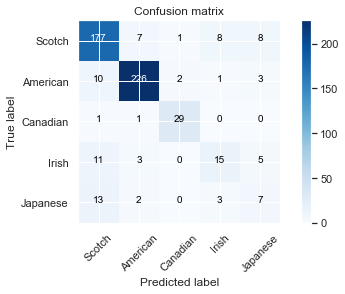

In [209]:
score_model(knn_model, "Tomek Links", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [210]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### Decision Tree

In [211]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 5)

Confusion Matrix, without normalization
[[166  30   0   0   5]
 [ 21 221   0   0   0]
 [  0   2  29   0   0]
 [ 18  16   0   0   0]
 [ 23   2   0   0   0]]


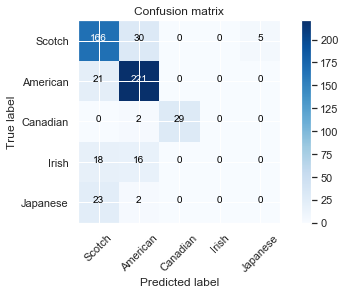

In [212]:
score_model(decision_tree_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [213]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


range(1, 10) - 0.7488261228988702
range(1, 10) - 0.8029457150730229
range(1, 10) - 0.8071617525489115
range(1, 10) - 0.8129291815927253
range(1, 10) - 0.841303389363461
range(1, 10) - 0.8486470101956464
range(1, 10) - 0.8502314687241664
range(1, 10) - 0.8413144116836595
range(1, 10) - 0.8276494902176909


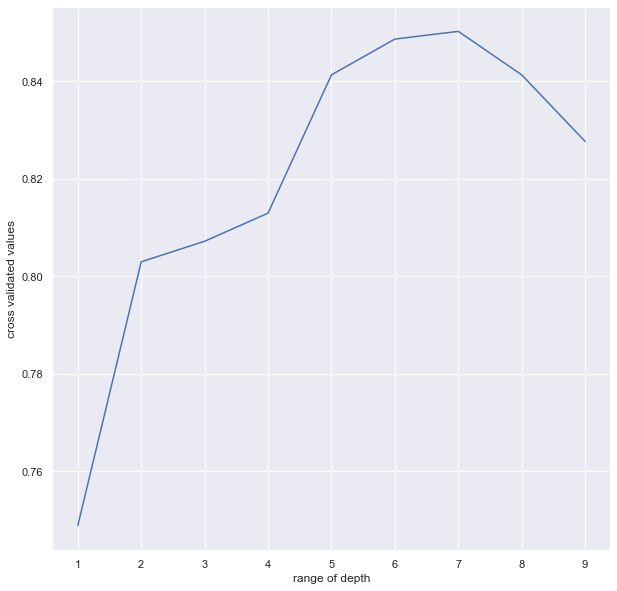

In [214]:
decision_tree_best_model(balanced['X_train'], balanced['y_train'])

In [215]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 6)

Confusion Matrix, without normalization
[[176  21   0   0   4]
 [ 19 223   0   0   0]
 [  0   2  29   0   0]
 [ 19  15   0   0   0]
 [ 24   1   0   0   0]]


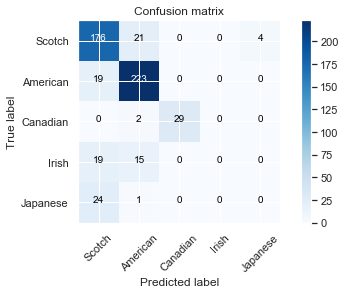

In [216]:
score_model(decision_tree_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [217]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### Random Forest

In [218]:
random_forest_model = random_forest(balanced_rf['X_train'], balanced_rf['y_train'], None, True)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Confusion Matrix, without normalization
[[190  11   0   0   0]
 [  7 235   0   0   0]
 [  1   4  26   0   0]
 [ 18  10   0   6   0]
 [ 17   3   0   0   5]]


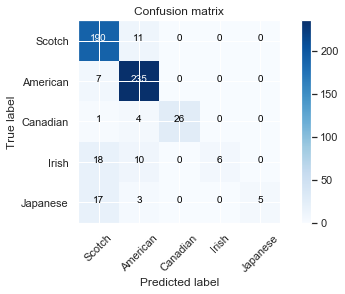

In [219]:
score_model(random_forest_model, "Tomek Links", balanced_rf['X_train'], balanced_rf['y_train'], split_rf['X_test'], split_rf['y_test'])

In [220]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


In [221]:
# n_estimators = [10, 50, 100, 150, 200]
# max_features = ['auto', 'sqrt','log2', 14]
# max_depth =[2,5,7,10]
# min_samples_leaf=[1]
# min_samples_split=[2]
# bootstrap = [True, False]

n_estimators = [200]
max_features = ['auto']
max_depth =[10]
min_samples_leaf=[1]
min_samples_split=[2]
bootstrap = [True]

# Create the random grid
param_grid = {  'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                'min_samples_split': min_samples_split,
                'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [200], 'max_features': ['auto'], 'max_depth': [10], 'min_samples_leaf': [1], 'min_samples_split': [2], 'bootstrap': [True]}


In [222]:
params = grid_search_cv(random_forest_model, features, target, param_grid, 4, 5)
print (params)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [223]:
random_forest_model = random_forest(balanced_rf['X_train'], balanced_rf['y_train'], params, False)

Confusion Matrix, without normalization
[[188  13   0   0   0]
 [  7 234   1   0   0]
 [  1   5  25   0   0]
 [ 18  13   0   3   0]
 [ 17   1   0   0   7]]


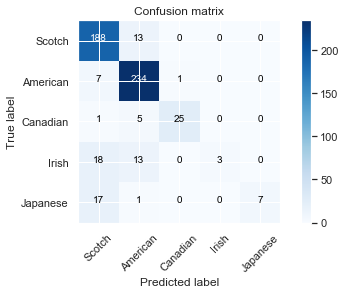

In [224]:
score_model(random_forest_model, "Tomek Links", balanced_rf['X_train'], balanced_rf['y_train'], split_rf['X_test'], split_rf['y_test'])

In [225]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### Adaptive Boosting

In [226]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], None, True)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=100, random_state=42)


Confusion Matrix, without normalization
[[137  11   0   8  45]
 [ 18 207  11   0   6]
 [  1   0  30   0   0]
 [ 17   3   0   8   6]
 [ 12   2   0   0  11]]


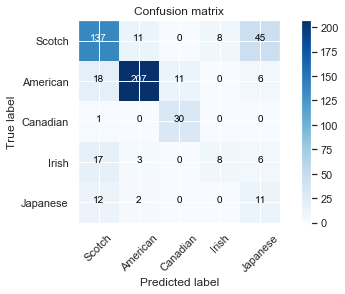

In [227]:
score_model(adaboost_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [228]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


In [229]:
# n_estimators = [500, 1000, 2000]
# learning_rate = [.001,0.01,.1]
# random_state = [42]

n_estimators = [500]
learning_rate = [.1]
random_state = [42]

param_grid = {  'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'random_state': random_state
             }
print(param_grid)

{'n_estimators': [500], 'learning_rate': [0.1], 'random_state': [42]}


In [230]:
params = grid_search_cv(adaboost_model, features, target, param_grid, 4, 5)
print (params)

{'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 42}


In [231]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[197   3   0   1   0]
 [ 22 215   4   1   0]
 [  1   1  29   0   0]
 [ 21   4   0   9   0]
 [ 21   2   0   0   2]]


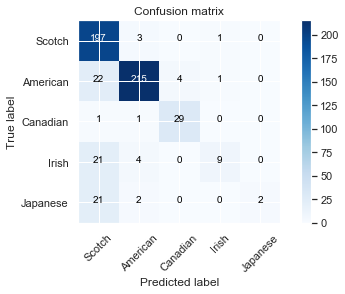

In [232]:
score_model(adaboost_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [233]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### Gradient Boost

In [234]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], None, True)

Confusion Matrix, without normalization
[[156  40   0   0   5]
 [ 15 227   0   0   0]
 [  1   1  29   0   0]
 [ 11  18   0   5   0]
 [ 10  14   0   0   1]]


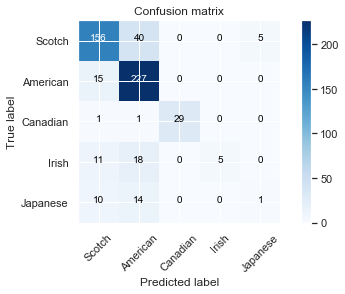

In [235]:
score_model(gradient_boost_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [236]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


In [237]:
# param_grid = {
#     "loss":["deviance", "exponential"],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "min_samples_split": [2],
#     "min_samples_leaf": [1],
#     "max_depth":[3,5,10],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[1.0],
#     "n_estimators":[50, 100, 200]
#     }

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.1],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_depth":[10],
    "max_features":["auto"],
    "criterion": ["friedman_mse"],
    "subsample":[1.0],
    "n_estimators":[100]
    }


# print(param_grid)

In [238]:
params = grid_search_cv(gradient_boost_model, features, target, param_grid, 4, 5)
print (params)

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}


In [239]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[183  12   0   1   5]
 [  8 231   0   1   2]
 [  0   2  29   0   0]
 [ 17   5   0  11   1]
 [ 17   2   0   0   6]]


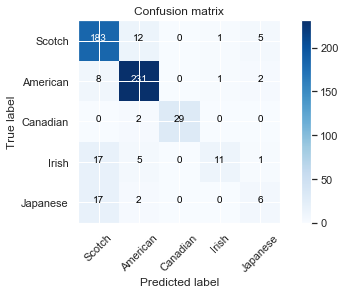

In [240]:
score_model(gradient_boost_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [241]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### XGBoost

In [242]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], None, True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Confusion Matrix, without normalization
[[183  12   0   2   4]
 [ 11 231   0   0   0]
 [  1   1  29   0   0]
 [ 17   8   0   9   0]
 [ 17   1   0   0   7]]


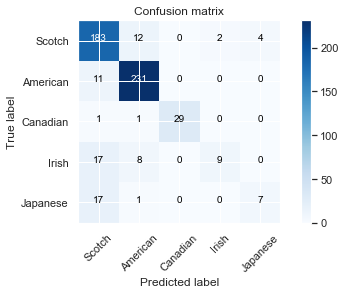

In [243]:
score_model(xgboost_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [244]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


In [245]:
# param_grid = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

param_grid = {
        'min_child_weight': [10],
        'gamma': [1.5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [5]
        }

# print(param_grid)

In [246]:
params = grid_search_cv(xgboost_model, features, target, param_grid, 4, 5)
print (params)

{'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 1.0}


In [247]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[183  16   0   1   1]
 [ 11 230   0   1   0]
 [  1   1  29   0   0]
 [ 19   9   0   6   0]
 [ 14   1   0   0  10]]


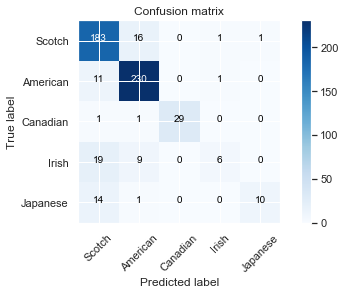

In [248]:
score_model(xgboost_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [249]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### Naive Bayes

In [250]:
naive_bayes_model = naive_bayes(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[ 19   0   0  28 154]
 [  0 139  41  24  38]
 [  0   0  30   0   1]
 [  0   0   0  20  14]
 [  1   0   0   1  23]]


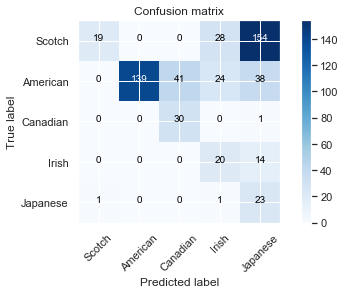

In [251]:
score_model(naive_bayes_model, "Tomek Links", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [252]:
split = data_split(features,target)

In [253]:
balanced = random_undersampling(split['X_train'], split['y_train'])

## Model Fitting and Hyperparameter Tuning (with Cluster Centroids)

In [254]:
balanced = cluster_centroids(split['X_train'], split['y_train'])
balanced_rf = cluster_centroids(split_rf['X_train'], split_rf['y_train'])

### Logistic Regression

In [255]:
logistic_regression_model = logistic_regression(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[41 18 12 51 79]
 [ 5 96 73 41 27]
 [ 1  1 22  2  5]
 [ 0  4 10 14  6]
 [ 1  1  2  3 18]]


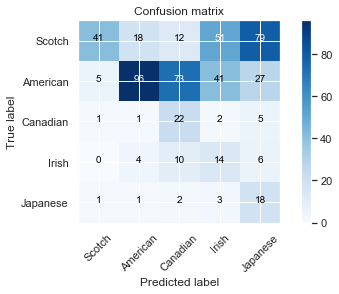

In [256]:
score_model(logistic_regression_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [257]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### K-Nearest Neighbor

In [258]:
scaled = scaler(balanced['X_train'], split['X_test'])

In [259]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[ 24   1   4  71 101]
 [  2 121  56  24  39]
 [  0   0  30   1   0]
 [  1   1   0  22  10]
 [  1   0   3   2  19]]


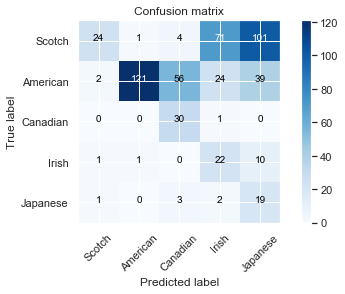

In [260]:
score_model(knn_model, "Cluster Centroids", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [261]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


n = 1 - 0.4356313552834633
n = 2 - 0.4839268149754708
n = 3 - 0.4873223786620599
n = 4 - 0.46504754378067015
n = 5 - 0.4737411848321283
n = 6 - 0.46441329475134346
n = 7 - 0.4845056338931365
n = 8 - 0.4955268244330139
n = 9 - 0.4911250934091183
n = 10 - 0.4828867339269973


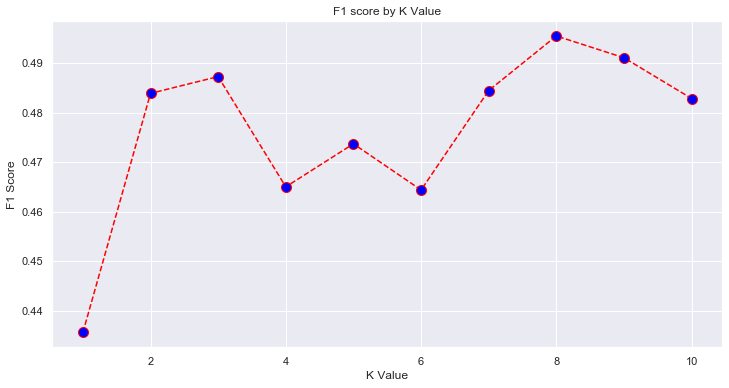

In [262]:
knn_best_model(scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [263]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[ 24   1   4  71 101]
 [  2 121  56  24  39]
 [  0   0  30   1   0]
 [  1   1   0  22  10]
 [  1   0   3   2  19]]


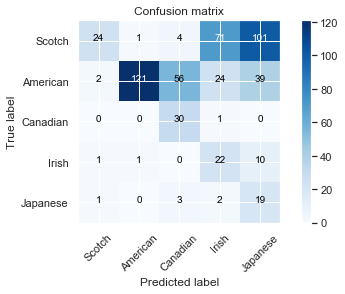

In [264]:
score_model(knn_model, "Cluster Centroids", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [265]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


### Decision Tree

In [266]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 5)

Confusion Matrix, without normalization
[[ 43   1   0  85  72]
 [ 11   9  30 138  54]
 [  0   0  29   1   1]
 [  1   0   0  20  13]
 [  2   0   0   2  21]]


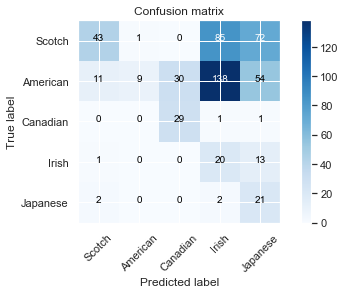

In [267]:
score_model(decision_tree_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [268]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
5,RandomForestClassifier,None,0.872,0.886,0.872,0.849,0.892
6,RandomForestClassifier,None,0.861,0.878,0.861,0.833,0.882
7,AdaBoostClassifier,None,0.735,0.774,0.735,0.752,0.825
8,AdaBoostClassifier,None,0.841,0.837,0.841,0.817,0.875
9,GradientBoostingClassifier,None,0.784,0.778,0.784,0.755,0.815


range(1, 10) - 0.3348837209302326
range(1, 10) - 0.5023255813953489
range(1, 10) - 0.672093023255814
range(1, 10) - 0.6813953488372093
range(1, 10) - 0.702325581395349
range(1, 10) - 0.7069767441860464
range(1, 10) - 0.6767441860465117
range(1, 10) - 0.6604651162790698
range(1, 10) - 0.6511627906976745


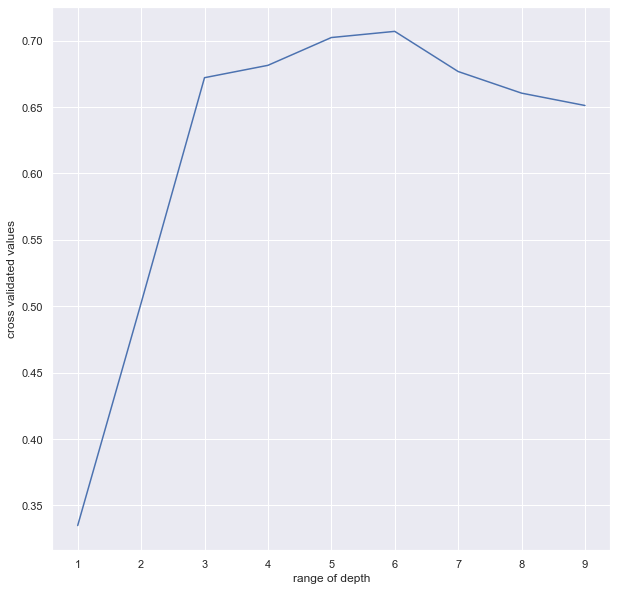

In [269]:
decision_tree_best_model(balanced['X_train'], balanced['y_train'])

In [270]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 6)

Confusion Matrix, without normalization
[[ 34   1   0  95  71]
 [ 36  10  30 137  29]
 [  0   0  29   1   1]
 [  3   0   0  19  12]
 [  2   0   0   3  20]]


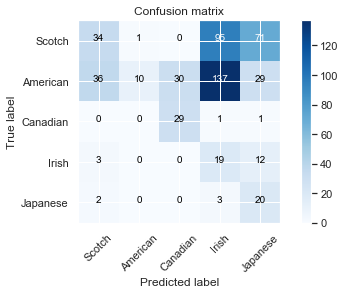

In [271]:
score_model(decision_tree_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [272]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
56,LogisticRegression,Cluster Centroids,0.358,0.710,0.358,0.405,0.639
57,KNeighborsClassifier,Cluster Centroids,0.405,0.806,0.405,0.436,0.682
58,KNeighborsClassifier,Cluster Centroids,0.405,0.806,0.405,0.436,0.682
59,DecisionTreeClassifier,Cluster Centroids,0.229,0.733,0.229,0.215,0.583


### Random Forest

In [273]:
random_forest_model = random_forest(balanced_rf['X_train'], balanced_rf['y_train'], None, True)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Confusion Matrix, without normalization
[[ 16   0   1  99  85]
 [  1  13  76 115  37]
 [  0   0  30   1   0]
 [  1   0   4  24   5]
 [  0   0   0   4  21]]


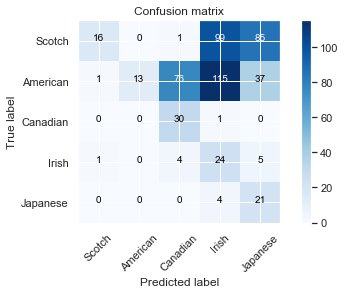

In [274]:
score_model(random_forest_model, "Cluster Centroids", balanced_rf['X_train'], balanced_rf['y_train'], split_rf['X_test'], split_rf['y_test'])

In [275]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
57,KNeighborsClassifier,Cluster Centroids,0.405,0.806,0.405,0.436,0.682
58,KNeighborsClassifier,Cluster Centroids,0.405,0.806,0.405,0.436,0.682
59,DecisionTreeClassifier,Cluster Centroids,0.229,0.733,0.229,0.215,0.583
60,DecisionTreeClassifier,Cluster Centroids,0.210,0.624,0.210,0.187,0.559


In [276]:
# n_estimators = [10, 50, 100, 150, 200]
# max_features = ['auto', 'sqrt','log2', 14]
# max_depth =[2,5,7,10]
# min_samples_leaf=[1]
# min_samples_split=[2]
# bootstrap = [True, False]

n_estimators = [200]
max_features = ['auto']
max_depth =[10]
min_samples_leaf=[1]
min_samples_split=[2]
bootstrap = [True]

# Create the random grid
param_grid = {  'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                'min_samples_split': min_samples_split,
                'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [200], 'max_features': ['auto'], 'max_depth': [10], 'min_samples_leaf': [1], 'min_samples_split': [2], 'bootstrap': [True]}


In [277]:
params = grid_search_cv(random_forest_model, features, target, param_grid, 4, 5)
print (params)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [278]:
random_forest_model = random_forest(balanced_rf['X_train'], balanced_rf['y_train'], params, False)

Confusion Matrix, without normalization
[[ 18   0   1  91  91]
 [  0  11  71 124  36]
 [  0   0  30   1   0]
 [  1   0   4  24   5]
 [  0   0   0   5  20]]


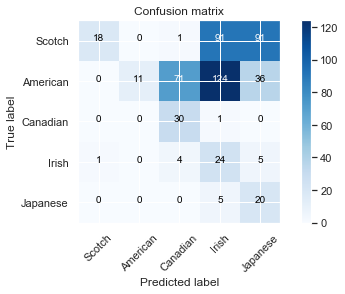

In [279]:
score_model(random_forest_model, "Cluster Centroids", balanced_rf['X_train'], balanced_rf['y_train'], split_rf['X_test'], split_rf['y_test'])

In [280]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
58,KNeighborsClassifier,Cluster Centroids,0.405,0.806,0.405,0.436,0.682
59,DecisionTreeClassifier,Cluster Centroids,0.229,0.733,0.229,0.215,0.583
60,DecisionTreeClassifier,Cluster Centroids,0.210,0.624,0.210,0.187,0.559
61,RandomForestClassifier,Cluster Centroids,0.195,0.818,0.195,0.148,0.572


### Adaptive Boosting

In [281]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], None, True)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=100, random_state=42)


Confusion Matrix, without normalization
[[  6   4   4 142  45]
 [  0  13  64 138  27]
 [  0   0  29   2   0]
 [  0   0   3  29   2]
 [  1   0   0  16   8]]


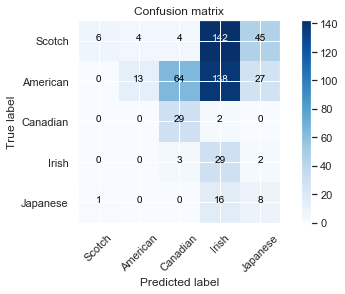

In [282]:
score_model(adaboost_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [283]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
59,DecisionTreeClassifier,Cluster Centroids,0.229,0.733,0.229,0.215,0.583
60,DecisionTreeClassifier,Cluster Centroids,0.210,0.624,0.210,0.187,0.559
61,RandomForestClassifier,Cluster Centroids,0.195,0.818,0.195,0.148,0.572
62,RandomForestClassifier,Cluster Centroids,0.193,0.840,0.193,0.148,0.571


In [284]:
# n_estimators = [500, 1000, 2000]
# learning_rate = [.001,0.01,.1]
# random_state = [42]

n_estimators = [500]
learning_rate = [.1]
random_state = [42]

param_grid = {  'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'random_state': random_state
             }
print(param_grid)

{'n_estimators': [500], 'learning_rate': [0.1], 'random_state': [42]}


In [285]:
params = grid_search_cv(adaboost_model, features, target, param_grid, 4, 5)
print (params)

{'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 42}


In [286]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[ 16   0   1 146  38]
 [  1   7  47 167  20]
 [  0   0  30   1   0]
 [  0   0   0  32   2]
 [  1   0   0  10  14]]


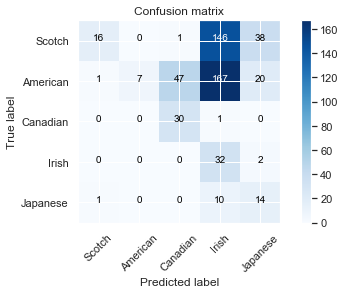

In [287]:
score_model(adaboost_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [288]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
60,DecisionTreeClassifier,Cluster Centroids,0.210,0.624,0.210,0.187,0.559
61,RandomForestClassifier,Cluster Centroids,0.195,0.818,0.195,0.148,0.572
62,RandomForestClassifier,Cluster Centroids,0.193,0.840,0.193,0.148,0.571
63,AdaBoostClassifier,Cluster Centroids,0.159,0.698,0.159,0.110,0.549


### Gradient Boost

In [289]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], None, True)

Confusion Matrix, without normalization
[[  0   1   0 146  54]
 [  0  15   0 212  15]
 [  0   0  29   2   0]
 [  0   0   0  30   4]
 [  0   0   0  17   8]]


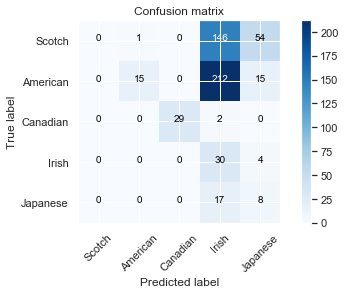

In [290]:
score_model(gradient_boost_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [291]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
61,RandomForestClassifier,Cluster Centroids,0.195,0.818,0.195,0.148,0.572
62,RandomForestClassifier,Cluster Centroids,0.193,0.840,0.193,0.148,0.571
63,AdaBoostClassifier,Cluster Centroids,0.159,0.698,0.159,0.110,0.549
64,AdaBoostClassifier,Cluster Centroids,0.186,0.826,0.186,0.136,0.565


In [292]:
# param_grid = {
#     "loss":["deviance", "exponential"],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "min_samples_split": [2],
#     "min_samples_leaf": [1],
#     "max_depth":[3,5,10],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[1.0],
#     "n_estimators":[50, 100, 200]
#     }

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.1],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_depth":[10],
    "max_features":["auto"],
    "criterion": ["friedman_mse"],
    "subsample":[1.0],
    "n_estimators":[100]
    }


# print(param_grid)

In [293]:
params = grid_search_cv(gradient_boost_model, features, target, param_grid, 4, 5)
print (params)

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}


In [294]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[22  4  4 82 89]
 [11 37 66 86 42]
 [ 0  0 30  1  0]
 [ 2  2  1 23  6]
 [ 3  0  1  8 13]]


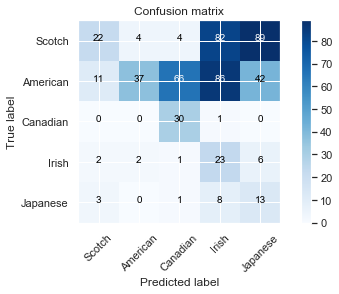

In [295]:
score_model(gradient_boost_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [296]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
62,RandomForestClassifier,Cluster Centroids,0.193,0.840,0.193,0.148,0.571
63,AdaBoostClassifier,Cluster Centroids,0.159,0.698,0.159,0.110,0.549
64,AdaBoostClassifier,Cluster Centroids,0.186,0.826,0.186,0.136,0.565
65,GradientBoostingClassifier,Cluster Centroids,0.154,0.493,0.154,0.125,0.549


### XGBoost

In [297]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], None, True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Confusion Matrix, without normalization
[[ 22   1   1 102  75]
 [  1  31  59 116  35]
 [  0   0  30   0   1]
 [  0   0   0  31   3]
 [  0   0   0   2  23]]


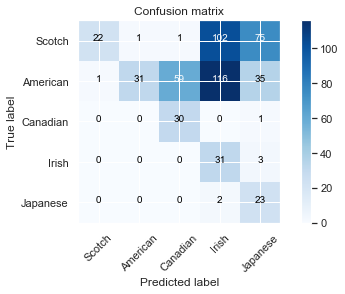

In [298]:
score_model(xgboost_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [299]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
63,AdaBoostClassifier,Cluster Centroids,0.159,0.698,0.159,0.110,0.549
64,AdaBoostClassifier,Cluster Centroids,0.186,0.826,0.186,0.136,0.565
65,GradientBoostingClassifier,Cluster Centroids,0.154,0.493,0.154,0.125,0.549
66,GradientBoostingClassifier,Cluster Centroids,0.235,0.638,0.235,0.233,0.582


In [300]:
# param_grid = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

param_grid = {
        'min_child_weight': [10],
        'gamma': [1.5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [5]
        }

# print(param_grid)

In [301]:
params = grid_search_cv(xgboost_model, features, target, param_grid, 4, 5)
print (params)

{'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 1.0}


In [302]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[ 12   2   3  88  96]
 [  1  28  41 133  39]
 [  0   0  29   1   1]
 [  0   0   1  26   7]
 [  0   0   0   2  23]]


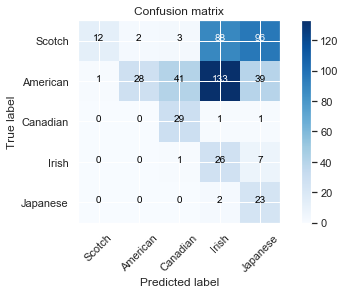

In [303]:
score_model(xgboost_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [304]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
64,AdaBoostClassifier,Cluster Centroids,0.186,0.826,0.186,0.136,0.565
65,GradientBoostingClassifier,Cluster Centroids,0.154,0.493,0.154,0.125,0.549
66,GradientBoostingClassifier,Cluster Centroids,0.235,0.638,0.235,0.233,0.582
67,XGBClassifier,Cluster Centroids,0.257,0.836,0.257,0.233,0.604


### Naive Bayes

In [305]:
naive_bayes_model = naive_bayes(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[ 65  12   0   9 115]
 [  0 138  49  19  36]
 [  0   0  30   0   1]
 [  6  14   0   8   6]
 [  1   5   1   0  18]]


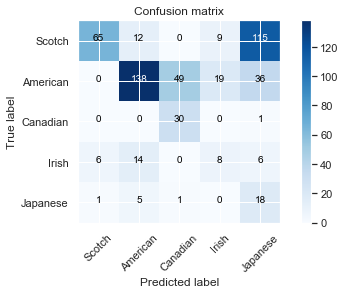

In [306]:
score_model(naive_bayes_model, "Cluster Centroids", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

## Model Fitting and Hyperparameter Tuning (with SMOTE)

In [307]:
balanced = smote(split['X_train'], split['y_train'])
balanced_rf = smote(split_rf['X_train'], split_rf['y_train'])

### Logistic Regression

In [308]:
logistic_regression_model = logistic_regression(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[105  21   9  21  45]
 [ 13 171  29  16  13]
 [  1   1  23   3   3]
 [  7   4   7  12   4]
 [  7   2   2   2  12]]


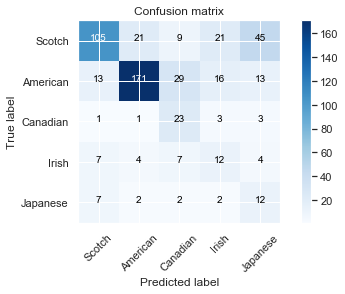

In [309]:
score_model(logistic_regression_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [310]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
66,GradientBoostingClassifier,Cluster Centroids,0.235,0.638,0.235,0.233,0.582
67,XGBClassifier,Cluster Centroids,0.257,0.836,0.257,0.233,0.604
68,XGBClassifier,Cluster Centroids,0.221,0.808,0.221,0.191,0.585
69,GaussianNB,Cluster Centroids,0.486,0.752,0.486,0.539,0.703


### K-Nearest Neighbor

In [311]:
scaled = scaler(balanced['X_train'], split['X_test'])

In [312]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[157   2   2  22  18]
 [  7 223   6   2   4]
 [  1   1  28   1   0]
 [ 10   3   0  17   4]
 [ 12   1   0   3   9]]


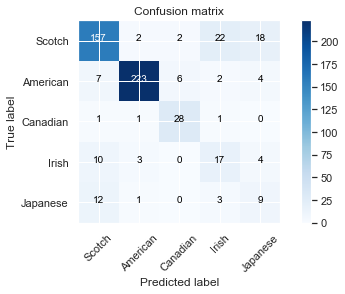

In [313]:
score_model(knn_model, "SMOTE", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [314]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
67,XGBClassifier,Cluster Centroids,0.257,0.836,0.257,0.233,0.604
68,XGBClassifier,Cluster Centroids,0.221,0.808,0.221,0.191,0.585
69,GaussianNB,Cluster Centroids,0.486,0.752,0.486,0.539,0.703
70,LogisticRegression,SMOTE,0.606,0.728,0.606,0.644,0.757


n = 1 - 0.8243485912432102
n = 2 - 0.8397185083182376
n = 3 - 0.8114440101510936
n = 4 - 0.8161388345252767
n = 5 - 0.7934126187493148
n = 6 - 0.7967986145126416
n = 7 - 0.790483307664591
n = 8 - 0.7956852525209724
n = 9 - 0.7927269078096831
n = 10 - 0.7993760552555965


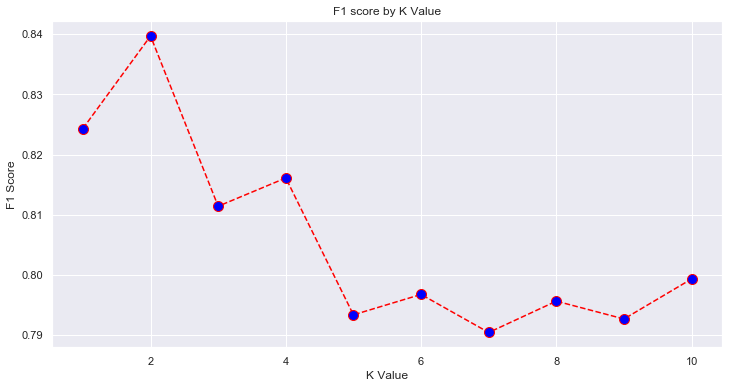

In [315]:
knn_best_model(scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [316]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[157   2   2  22  18]
 [  7 223   6   2   4]
 [  1   1  28   1   0]
 [ 10   3   0  17   4]
 [ 12   1   0   3   9]]


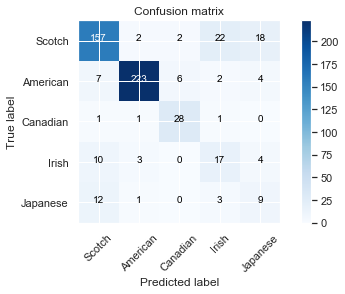

In [317]:
score_model(knn_model, "SMOTE", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [318]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
68,XGBClassifier,Cluster Centroids,0.221,0.808,0.221,0.191,0.585
69,GaussianNB,Cluster Centroids,0.486,0.752,0.486,0.539,0.703
70,LogisticRegression,SMOTE,0.606,0.728,0.606,0.644,0.757
71,KNeighborsClassifier,SMOTE,0.814,0.838,0.814,0.824,0.881


### Decision Tree

In [319]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 5)

Confusion Matrix, without normalization
[[126  16   0  31  28]
 [  3 154   0  73  12]
 [  0   1  29   1   0]
 [ 11   0   0  19   4]
 [  6   2   0   4  13]]


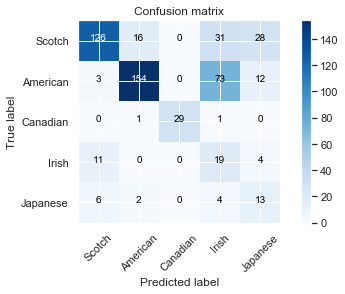

In [320]:
score_model(decision_tree_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [321]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
69,GaussianNB,Cluster Centroids,0.486,0.752,0.486,0.539,0.703
70,LogisticRegression,SMOTE,0.606,0.728,0.606,0.644,0.757
71,KNeighborsClassifier,SMOTE,0.814,0.838,0.814,0.824,0.881
72,KNeighborsClassifier,SMOTE,0.814,0.838,0.814,0.824,0.881


range(1, 10) - 0.3526315789473684
range(1, 10) - 0.44947368421052636
range(1, 10) - 0.5650526315789474
range(1, 10) - 0.6597894736842106
range(1, 10) - 0.7050526315789474
range(1, 10) - 0.7463157894736842
range(1, 10) - 0.7522105263157894
range(1, 10) - 0.78
range(1, 10) - 0.7928421052631579


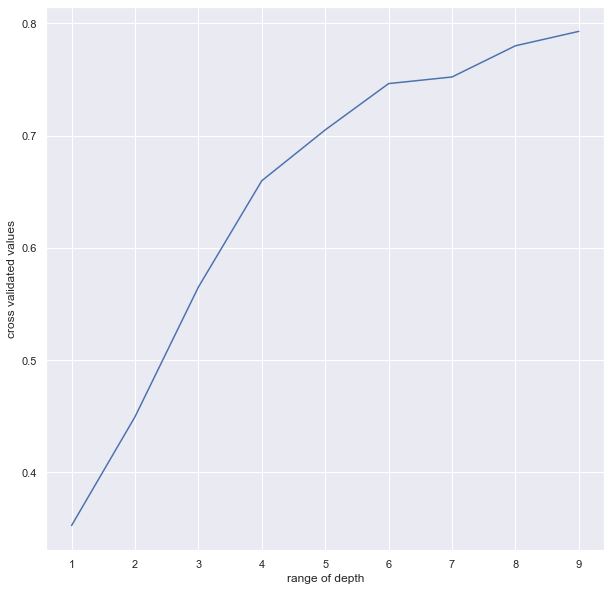

In [322]:
decision_tree_best_model(balanced['X_train'], balanced['y_train'])

In [323]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 6)

Confusion Matrix, without normalization
[[139  10   0  31  21]
 [  9 169   0  52  12]
 [  0   2  29   0   0]
 [ 11   0   0  20   3]
 [  7   1   0   4  13]]


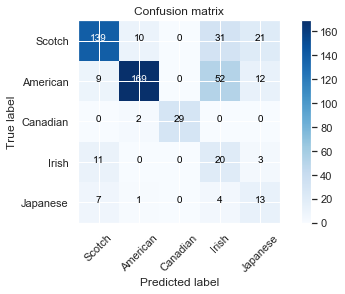

In [324]:
score_model(decision_tree_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [325]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
70,LogisticRegression,SMOTE,0.606,0.728,0.606,0.644,0.757
71,KNeighborsClassifier,SMOTE,0.814,0.838,0.814,0.824,0.881
72,KNeighborsClassifier,SMOTE,0.814,0.838,0.814,0.824,0.881
73,DecisionTreeClassifier,SMOTE,0.640,0.808,0.640,0.697,0.785


### Random Forest

In [326]:
random_forest_model = random_forest(balanced_rf['X_train'], balanced_rf['y_train'], None, True)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Confusion Matrix, without normalization
[[180  11   0   8   2]
 [  5 235   0   1   1]
 [  0   2  29   0   0]
 [ 15   8   0  11   0]
 [ 12   2   0   0  11]]


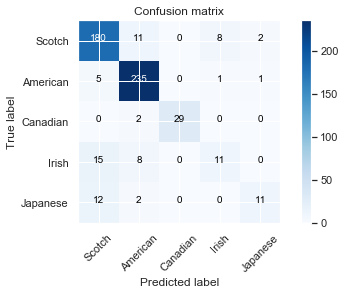

In [327]:
score_model(random_forest_model, "SMOTE", balanced_rf['X_train'], balanced_rf['y_train'], split_rf['X_test'], split_rf['y_test'])

In [328]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
71,KNeighborsClassifier,SMOTE,0.814,0.838,0.814,0.824,0.881
72,KNeighborsClassifier,SMOTE,0.814,0.838,0.814,0.824,0.881
73,DecisionTreeClassifier,SMOTE,0.640,0.808,0.640,0.697,0.785
74,DecisionTreeClassifier,SMOTE,0.694,0.820,0.694,0.738,0.814


In [329]:
# n_estimators = [10, 50, 100, 150, 200]
# max_features = ['auto', 'sqrt','log2', 14]
# max_depth =[2,5,7,10]
# min_samples_leaf=[1]
# min_samples_split=[2]
# bootstrap = [True, False]

n_estimators = [200]
max_features = ['auto']
max_depth =[10]
min_samples_leaf=[1]
min_samples_split=[2]
bootstrap = [True]

# Create the random grid
param_grid = {  'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                'min_samples_split': min_samples_split,
                'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [200], 'max_features': ['auto'], 'max_depth': [10], 'min_samples_leaf': [1], 'min_samples_split': [2], 'bootstrap': [True]}


In [330]:
params = grid_search_cv(random_forest_model, features, target, param_grid, 4, 5)
print (params)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [331]:
random_forest_model = random_forest(balanced_rf['X_train'], balanced_rf['y_train'], params, False)

Confusion Matrix, without normalization
[[169  13   0  14   5]
 [  4 234   2   1   1]
 [  0   2  29   0   0]
 [ 14   8   0  12   0]
 [ 12   3   0   1   9]]


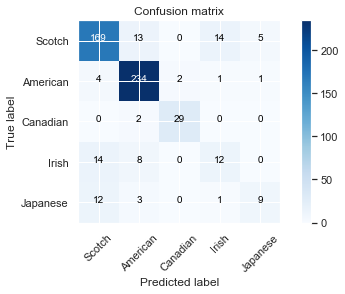

In [332]:
score_model(random_forest_model, "SMOTE", balanced_rf['X_train'], balanced_rf['y_train'], split_rf['X_test'], split_rf['y_test'])

In [333]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
72,KNeighborsClassifier,SMOTE,0.814,0.838,0.814,0.824,0.881
73,DecisionTreeClassifier,SMOTE,0.640,0.808,0.640,0.697,0.785
74,DecisionTreeClassifier,SMOTE,0.694,0.820,0.694,0.738,0.814
75,RandomForestClassifier,SMOTE,0.874,0.864,0.874,0.864,0.900


### Adaptive Boosting

In [334]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], None, True)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=100, random_state=42)


Confusion Matrix, without normalization
[[145  14   2  16  24]
 [ 12 212  11   6   1]
 [  1   1  29   0   0]
 [ 13   2   1  14   4]
 [ 11   1   0   0  13]]


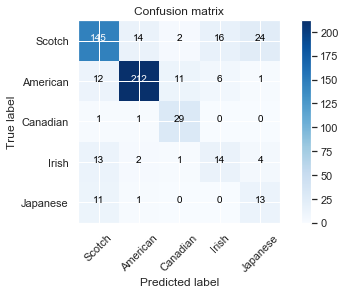

In [335]:
score_model(adaboost_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [336]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
73,DecisionTreeClassifier,SMOTE,0.640,0.808,0.640,0.697,0.785
74,DecisionTreeClassifier,SMOTE,0.694,0.820,0.694,0.738,0.814
75,RandomForestClassifier,SMOTE,0.874,0.864,0.874,0.864,0.900
76,RandomForestClassifier,SMOTE,0.850,0.839,0.850,0.842,0.886


In [337]:
# n_estimators = [500, 1000, 2000]
# learning_rate = [.001,0.01,.1]
# random_state = [42]

n_estimators = [500]
learning_rate = [.1]
random_state = [42]

param_grid = {  'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'random_state': random_state
             }
print(param_grid)

{'n_estimators': [500], 'learning_rate': [0.1], 'random_state': [42]}


In [338]:
params = grid_search_cv(adaboost_model, features, target, param_grid, 4, 5)
print (params)

{'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 42}


In [339]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[167   0   0  22  12]
 [ 15 204  13   8   2]
 [  1   1  29   0   0]
 [ 14   1   0  16   3]
 [ 12   1   0   0  12]]


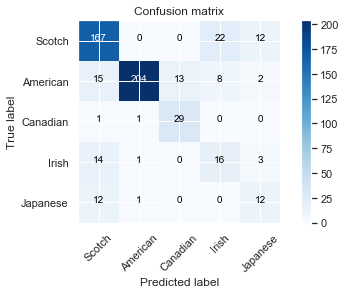

In [340]:
score_model(adaboost_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [341]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
74,DecisionTreeClassifier,SMOTE,0.694,0.820,0.694,0.738,0.814
75,RandomForestClassifier,SMOTE,0.874,0.864,0.874,0.864,0.900
76,RandomForestClassifier,SMOTE,0.850,0.839,0.850,0.842,0.886
77,AdaBoostClassifier,SMOTE,0.775,0.797,0.775,0.783,0.849


### Gradient Boost

In [342]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], None, True)

Confusion Matrix, without normalization
[[156   0   0  23  22]
 [ 15 112   0  90  25]
 [  1   0  29   0   1]
 [ 11   0   0  16   7]
 [ 10   0   0   1  14]]


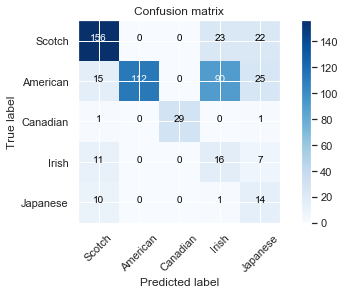

In [343]:
score_model(gradient_boost_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [344]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
75,RandomForestClassifier,SMOTE,0.874,0.864,0.874,0.864,0.900
76,RandomForestClassifier,SMOTE,0.850,0.839,0.850,0.842,0.886
77,AdaBoostClassifier,SMOTE,0.775,0.797,0.775,0.783,0.849
78,AdaBoostClassifier,SMOTE,0.803,0.831,0.803,0.812,0.872


In [345]:
# param_grid = {
#     "loss":["deviance", "exponential"],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "min_samples_split": [2],
#     "min_samples_leaf": [1],
#     "max_depth":[3,5,10],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[1.0],
#     "n_estimators":[50, 100, 200]
#     }

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.1],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_depth":[10],
    "max_features":["auto"],
    "criterion": ["friedman_mse"],
    "subsample":[1.0],
    "n_estimators":[100]
    }


# print(param_grid)

In [346]:
params = grid_search_cv(gradient_boost_model, features, target, param_grid, 4, 5)
print (params)

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}


In [347]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[178   5   1  10   7]
 [  5 234   1   2   0]
 [  1   1  29   0   0]
 [ 16   3   0  13   2]
 [ 13   1   0   3   8]]


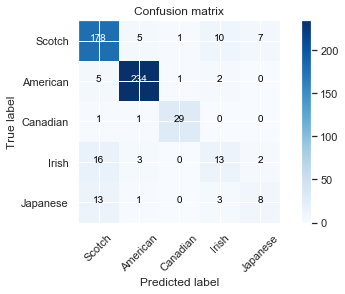

In [348]:
score_model(gradient_boost_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [349]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
76,RandomForestClassifier,SMOTE,0.850,0.839,0.850,0.842,0.886
77,AdaBoostClassifier,SMOTE,0.775,0.797,0.775,0.783,0.849
78,AdaBoostClassifier,SMOTE,0.803,0.831,0.803,0.812,0.872
79,GradientBoostingClassifier,SMOTE,0.614,0.834,0.614,0.669,0.776


### XGBoost

In [350]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], None, True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Confusion Matrix, without normalization
[[169   4   2  15  11]
 [ 10 222   4   6   0]
 [  1   1  29   0   0]
 [ 15   2   1  16   0]
 [ 10   1   0   0  14]]


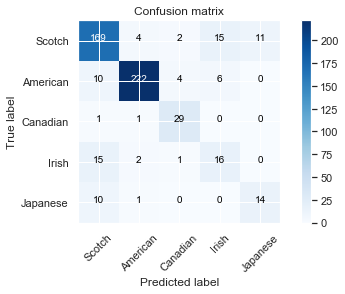

In [351]:
score_model(xgboost_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [352]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
77,AdaBoostClassifier,SMOTE,0.775,0.797,0.775,0.783,0.849
78,AdaBoostClassifier,SMOTE,0.803,0.831,0.803,0.812,0.872
79,GradientBoostingClassifier,SMOTE,0.614,0.834,0.614,0.669,0.776
80,GradientBoostingClassifier,SMOTE,0.867,0.857,0.867,0.861,0.904


In [353]:
# param_grid = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

param_grid = {
        'min_child_weight': [10],
        'gamma': [1.5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [5]
        }

# print(param_grid)

In [354]:
params = grid_search_cv(xgboost_model, features, target, param_grid, 4, 5)
print (params)

{'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 1.0}


In [355]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[179   5   2  10   5]
 [  9 225   3   5   0]
 [  1   1  29   0   0]
 [ 17   3   1  13   0]
 [ 10   1   1   1  12]]


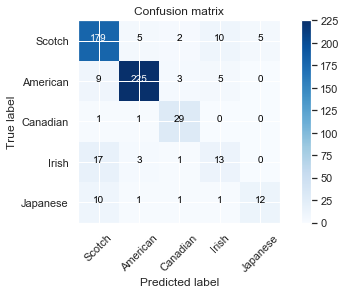

In [356]:
score_model(xgboost_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [357]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
78,AdaBoostClassifier,SMOTE,0.803,0.831,0.803,0.812,0.872
79,GradientBoostingClassifier,SMOTE,0.614,0.834,0.614,0.669,0.776
80,GradientBoostingClassifier,SMOTE,0.867,0.857,0.867,0.861,0.904
81,XGBClassifier,SMOTE,0.844,0.850,0.844,0.846,0.893


### Naive Bayes

In [358]:
naive_bayes_model = naive_bayes(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[ 61   0   0  46  94]
 [  5 158  35  11  33]
 [  0   0  30   0   1]
 [  5   0   0  21   8]
 [  4   0   0   3  18]]


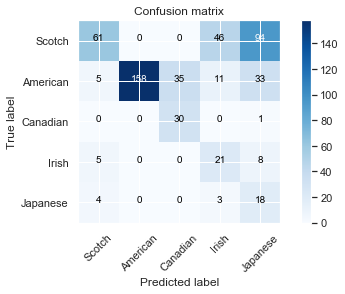

In [359]:
score_model(naive_bayes_model, "SMOTE", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [360]:
split = data_split(features,target)

In [361]:
balanced = random_undersampling(split['X_train'], split['y_train'])

## Model Fitting and Hyperparameter Tuning (with Cluster Centroids)

In [362]:
balanced = smote_tomek(split['X_train'], split['y_train'])
balanced_rf = smote_tomek(split_rf['X_train'], split_rf['y_train'])

### Logistic Regression

In [363]:
logistic_regression_model = logistic_regression(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[107  17  12  20  45]
 [ 11 161  36  22  12]
 [  0   1  24   3   3]
 [  6   3   8  13   4]
 [  6   2   1   2  14]]


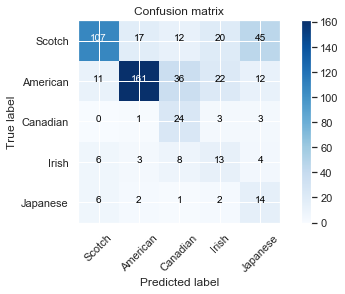

In [364]:
score_model(logistic_regression_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [365]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
80,GradientBoostingClassifier,SMOTE,0.867,0.857,0.867,0.861,0.904
81,XGBClassifier,SMOTE,0.844,0.850,0.844,0.846,0.893
82,XGBClassifier,SMOTE,0.859,0.856,0.859,0.856,0.899
83,GaussianNB,SMOTE,0.540,0.810,0.540,0.594,0.750


### K-Nearest Neighbor

In [366]:
scaled = scaler(balanced['X_train'], split['X_test'])

In [367]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[157   2   2  22  18]
 [  6 223   6   3   4]
 [  1   1  28   1   0]
 [ 11   1   0  18   4]
 [ 13   0   0   3   9]]


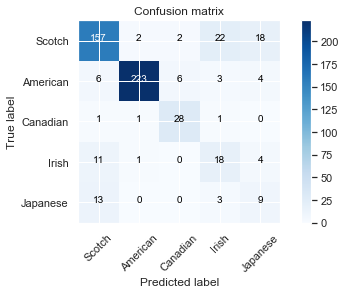

In [368]:
score_model(knn_model, "SMOTE Tomek", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [369]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
81,XGBClassifier,SMOTE,0.844,0.850,0.844,0.846,0.893
82,XGBClassifier,SMOTE,0.859,0.856,0.859,0.856,0.899
83,GaussianNB,SMOTE,0.540,0.810,0.540,0.594,0.750
84,LogisticRegression,SMOTE Tomek,0.598,0.747,0.598,0.642,0.759


n = 1 - 0.8272055190745643
n = 2 - 0.839644767217427
n = 3 - 0.8102329066832814
n = 4 - 0.8167060768543127
n = 5 - 0.7965512007770791
n = 6 - 0.8005478273194184
n = 7 - 0.7943508418189841
n = 8 - 0.8010290710514266
n = 9 - 0.7967929145214327
n = 10 - 0.8025874195418888


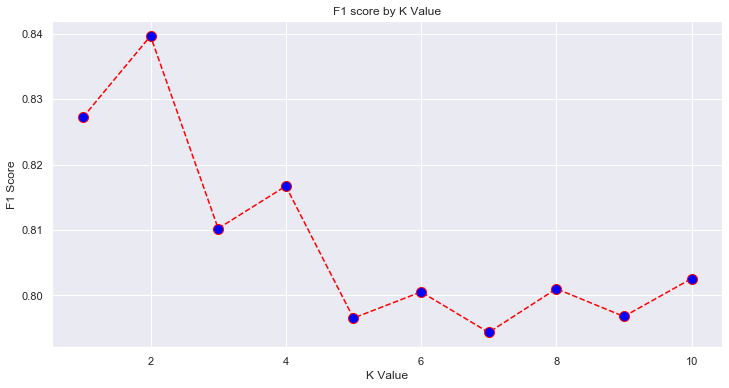

In [370]:
knn_best_model(scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [371]:
knn_model = knn(scaled['X_train_scaled'], balanced['y_train'], 1)

Confusion Matrix, without normalization
[[157   2   2  22  18]
 [  6 223   6   3   4]
 [  1   1  28   1   0]
 [ 11   1   0  18   4]
 [ 13   0   0   3   9]]


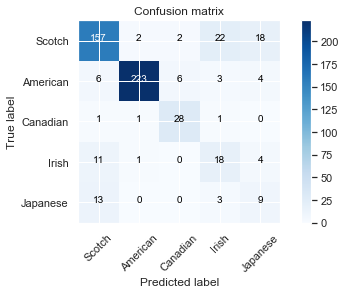

In [372]:
score_model(knn_model, "SMOTE Tomek", scaled['X_train_scaled'], balanced['y_train'], scaled['X_test_scaled'], split['y_test'])

In [373]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
82,XGBClassifier,SMOTE,0.859,0.856,0.859,0.856,0.899
83,GaussianNB,SMOTE,0.540,0.810,0.540,0.594,0.750
84,LogisticRegression,SMOTE Tomek,0.598,0.747,0.598,0.642,0.759
85,KNeighborsClassifier,SMOTE Tomek,0.816,0.843,0.816,0.827,0.884


### Decision Tree

In [374]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 5)

Confusion Matrix, without normalization
[[127  10   0  31  33]
 [  6 150   0  73  13]
 [  0   1  29   1   0]
 [ 11   0   0  19   4]
 [  6   1   0   4  14]]


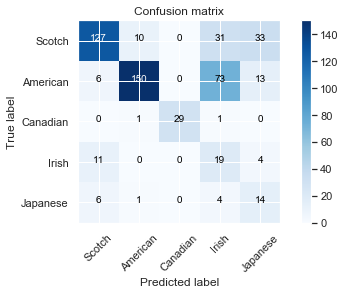

In [375]:
score_model(decision_tree_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [376]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
83,GaussianNB,SMOTE,0.540,0.810,0.540,0.594,0.750
84,LogisticRegression,SMOTE Tomek,0.598,0.747,0.598,0.642,0.759
85,KNeighborsClassifier,SMOTE Tomek,0.816,0.843,0.816,0.827,0.884
86,KNeighborsClassifier,SMOTE Tomek,0.816,0.843,0.816,0.827,0.884


range(1, 10) - 0.3572900151258361
range(1, 10) - 0.4524260565305342
range(1, 10) - 0.5684649098828203
range(1, 10) - 0.659769832157892
range(1, 10) - 0.7071218996592131
range(1, 10) - 0.7459479160971698
range(1, 10) - 0.7544821679150038
range(1, 10) - 0.7866892643012046
range(1, 10) - 0.797138392287646


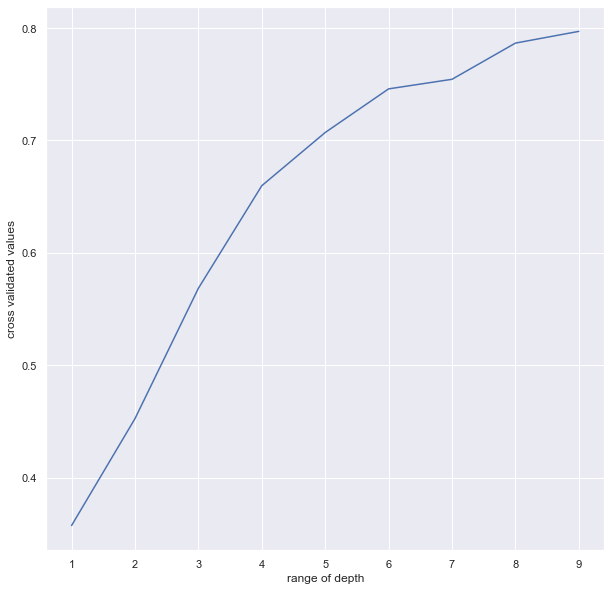

In [377]:
decision_tree_best_model(balanced['X_train'], balanced['y_train'])

In [378]:
decision_tree_model = decision_tree(balanced['X_train'], balanced['y_train'], 6)

Confusion Matrix, without normalization
[[139  10   0  31  21]
 [  9 169   0  52  12]
 [  0   2  29   0   0]
 [ 11   0   0  20   3]
 [  7   1   0   4  13]]


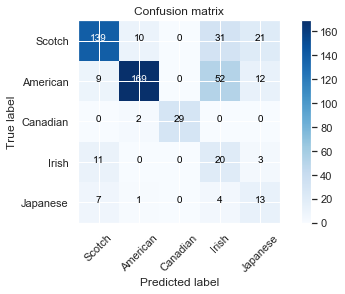

In [379]:
score_model(decision_tree_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [380]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
84,LogisticRegression,SMOTE Tomek,0.598,0.747,0.598,0.642,0.759
85,KNeighborsClassifier,SMOTE Tomek,0.816,0.843,0.816,0.827,0.884
86,KNeighborsClassifier,SMOTE Tomek,0.816,0.843,0.816,0.827,0.884
87,DecisionTreeClassifier,SMOTE Tomek,0.636,0.818,0.636,0.696,0.786


### Random Forest

In [381]:
random_forest_model = random_forest(balanced_rf['X_train'], balanced_rf['y_train'], None, True)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


Confusion Matrix, without normalization
[[179   9   0  12   1]
 [  6 231   3   1   1]
 [  1   1  29   0   0]
 [ 15   6   1  11   1]
 [ 13   3   0   1   8]]


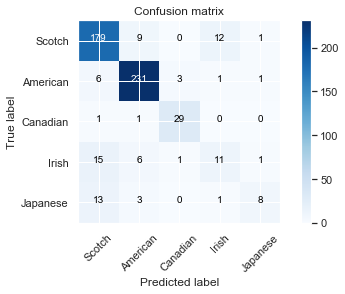

In [382]:
score_model(random_forest_model, "SMOTE Tomek", balanced_rf['X_train'], balanced_rf['y_train'], split_rf['X_test'], split_rf['y_test'])

In [383]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
85,KNeighborsClassifier,SMOTE Tomek,0.816,0.843,0.816,0.827,0.884
86,KNeighborsClassifier,SMOTE Tomek,0.816,0.843,0.816,0.827,0.884
87,DecisionTreeClassifier,SMOTE Tomek,0.636,0.818,0.636,0.696,0.786
88,DecisionTreeClassifier,SMOTE Tomek,0.694,0.820,0.694,0.738,0.814


In [384]:
# n_estimators = [10, 50, 100, 150, 200]
# max_features = ['auto', 'sqrt','log2', 14]
# max_depth =[2,5,7,10]
# min_samples_leaf=[1]
# min_samples_split=[2]
# bootstrap = [True, False]

n_estimators = [200]
max_features = ['auto']
max_depth =[10]
min_samples_leaf=[1]
min_samples_split=[2]
bootstrap = [True]

# Create the random grid
param_grid = {  'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                'min_samples_split': min_samples_split,
                'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [200], 'max_features': ['auto'], 'max_depth': [10], 'min_samples_leaf': [1], 'min_samples_split': [2], 'bootstrap': [True]}


In [385]:
params = grid_search_cv(random_forest_model, features, target, param_grid, 4, 5)
print (params)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [386]:
random_forest_model = random_forest(balanced_rf['X_train'], balanced_rf['y_train'], params, False)

Confusion Matrix, without normalization
[[171  13   0  13   4]
 [  4 234   1   2   1]
 [  0   2  29   0   0]
 [ 15   8   0  10   1]
 [ 11   2   0   1  11]]


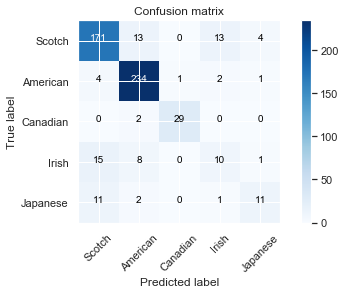

In [387]:
score_model(random_forest_model, "SMOTE Tomek", balanced_rf['X_train'], balanced_rf['y_train'], split_rf['X_test'], split_rf['y_test'])

In [388]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
86,KNeighborsClassifier,SMOTE Tomek,0.816,0.843,0.816,0.827,0.884
87,DecisionTreeClassifier,SMOTE Tomek,0.636,0.818,0.636,0.696,0.786
88,DecisionTreeClassifier,SMOTE Tomek,0.694,0.820,0.694,0.738,0.814
89,RandomForestClassifier,SMOTE Tomek,0.859,0.848,0.859,0.849,0.894


### Adaptive Boosting

In [389]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], None, True)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
                   n_estimators=100, random_state=42)


Confusion Matrix, without normalization
[[142  19   0  18  22]
 [ 11 210  14   6   1]
 [  1   1  29   0   0]
 [ 14   3   1  12   4]
 [ 12   1   0   0  12]]


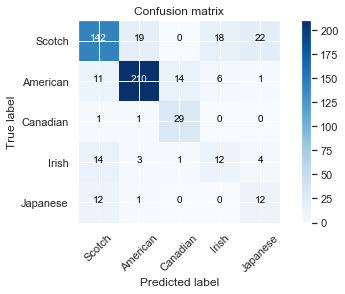

In [390]:
score_model(adaboost_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [391]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
87,DecisionTreeClassifier,SMOTE Tomek,0.636,0.818,0.636,0.696,0.786
88,DecisionTreeClassifier,SMOTE Tomek,0.694,0.820,0.694,0.738,0.814
89,RandomForestClassifier,SMOTE Tomek,0.859,0.848,0.859,0.849,0.894
90,RandomForestClassifier,SMOTE Tomek,0.854,0.842,0.854,0.846,0.889


In [392]:
# n_estimators = [500, 1000, 2000]
# learning_rate = [.001,0.01,.1]
# random_state = [42]

n_estimators = [500]
learning_rate = [.1]
random_state = [42]

param_grid = {  'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'random_state': random_state
             }
print(param_grid)

{'n_estimators': [500], 'learning_rate': [0.1], 'random_state': [42]}


In [393]:
params = grid_search_cv(adaboost_model, features, target, param_grid, 4, 5)
print (params)

{'learning_rate': 0.1, 'n_estimators': 500, 'random_state': 42}


In [394]:
adaboost_model = adaboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[164   2   0  22  13]
 [ 15 201  14  10   2]
 [  1   1  29   0   0]
 [ 15   1   0  16   2]
 [ 12   1   0   0  12]]


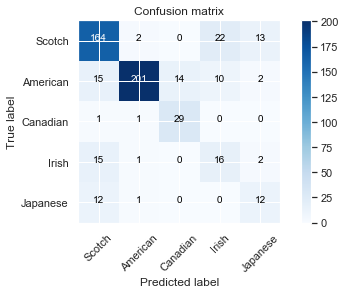

In [395]:
score_model(adaboost_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [396]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
88,DecisionTreeClassifier,SMOTE Tomek,0.694,0.820,0.694,0.738,0.814
89,RandomForestClassifier,SMOTE Tomek,0.859,0.848,0.859,0.849,0.894
90,RandomForestClassifier,SMOTE Tomek,0.854,0.842,0.854,0.846,0.889
91,AdaBoostClassifier,SMOTE Tomek,0.760,0.779,0.760,0.766,0.836


### Gradient Boost

In [397]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], None, True)

Confusion Matrix, without normalization
[[156   0   0  23  22]
 [ 15 112   0  90  25]
 [  1   0  29   0   1]
 [ 11   0   0  16   7]
 [ 10   0   0   1  14]]


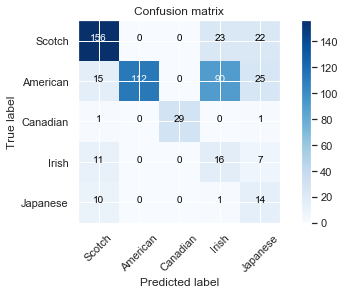

In [398]:
score_model(gradient_boost_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [399]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
89,RandomForestClassifier,SMOTE Tomek,0.859,0.848,0.859,0.849,0.894
90,RandomForestClassifier,SMOTE Tomek,0.854,0.842,0.854,0.846,0.889
91,AdaBoostClassifier,SMOTE Tomek,0.760,0.779,0.760,0.766,0.836
92,AdaBoostClassifier,SMOTE Tomek,0.792,0.822,0.792,0.802,0.864


In [400]:
# param_grid = {
#     "loss":["deviance", "exponential"],
#     "learning_rate": [0.01, 0.1, 0.2],
#     "min_samples_split": [2],
#     "min_samples_leaf": [1],
#     "max_depth":[3,5,10],
#     "max_features":["log2","sqrt"],
#     "criterion": ["friedman_mse",  "mae"],
#     "subsample":[1.0],
#     "n_estimators":[50, 100, 200]
#     }

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.1],
    "min_samples_split": [2],
    "min_samples_leaf": [1],
    "max_depth":[10],
    "max_features":["auto"],
    "criterion": ["friedman_mse"],
    "subsample":[1.0],
    "n_estimators":[100]
    }


# print(param_grid)

In [401]:
params = grid_search_cv(gradient_boost_model, features, target, param_grid, 4, 5)
print (params)

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}


In [402]:
gradient_boost_model = gradientboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[175   5   1  10  10]
 [  6 233   1   2   0]
 [  1   1  29   0   0]
 [ 14   2   0  15   3]
 [ 13   1   0   1  10]]


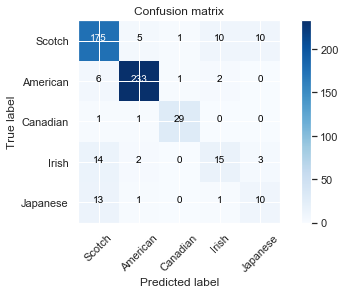

In [403]:
score_model(gradient_boost_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [404]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
90,RandomForestClassifier,SMOTE Tomek,0.854,0.842,0.854,0.846,0.889
91,AdaBoostClassifier,SMOTE Tomek,0.760,0.779,0.760,0.766,0.836
92,AdaBoostClassifier,SMOTE Tomek,0.792,0.822,0.792,0.802,0.864
93,GradientBoostingClassifier,SMOTE Tomek,0.614,0.834,0.614,0.669,0.776


### XGBoost

In [405]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], None, True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


Confusion Matrix, without normalization
[[166   5   2  16  12]
 [  9 219   5   6   3]
 [  1   1  29   0   0]
 [ 14   3   1  16   0]
 [ 11   1   0   1  12]]


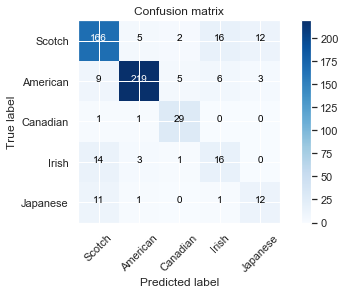

In [406]:
score_model(xgboost_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [407]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
91,AdaBoostClassifier,SMOTE Tomek,0.760,0.779,0.760,0.766,0.836
92,AdaBoostClassifier,SMOTE Tomek,0.792,0.822,0.792,0.802,0.864
93,GradientBoostingClassifier,SMOTE Tomek,0.614,0.834,0.614,0.669,0.776
94,GradientBoostingClassifier,SMOTE Tomek,0.867,0.862,0.867,0.864,0.906


In [408]:
# param_grid = {
#         'min_child_weight': [1, 5, 10],
#         'gamma': [0.5, 1, 1.5, 2, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 4, 5]
#         }

param_grid = {
        'min_child_weight': [10],
        'gamma': [1.5],
        'subsample': [1.0],
        'colsample_bytree': [1.0],
        'max_depth': [5]
        }

# print(param_grid)

In [409]:
params = grid_search_cv(xgboost_model, features, target, param_grid, 4, 5)
print (params)

{'colsample_bytree': 1.0, 'gamma': 1.5, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 1.0}


In [410]:
xgboost_model = xgboost(balanced['X_train'], balanced['y_train'], params, False)

Confusion Matrix, without normalization
[[176   5   0  14   6]
 [  9 224   4   5   0]
 [  1   1  29   0   0]
 [ 16   3   1  14   0]
 [ 11   1   1   1  11]]


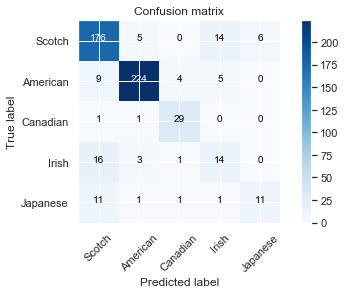

In [411]:
score_model(xgboost_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [412]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
92,AdaBoostClassifier,SMOTE Tomek,0.792,0.822,0.792,0.802,0.864
93,GradientBoostingClassifier,SMOTE Tomek,0.614,0.834,0.614,0.669,0.776
94,GradientBoostingClassifier,SMOTE Tomek,0.867,0.862,0.867,0.864,0.906
95,XGBClassifier,SMOTE Tomek,0.829,0.838,0.829,0.833,0.884


### Naive Bayes

In [413]:
naive_bayes_model = naive_bayes(balanced['X_train'], balanced['y_train'])

Confusion Matrix, without normalization
[[ 62   0   0  45  94]
 [  5 159  34  11  33]
 [  0   0  30   0   1]
 [  5   0   0  21   8]
 [  4   0   0   3  18]]


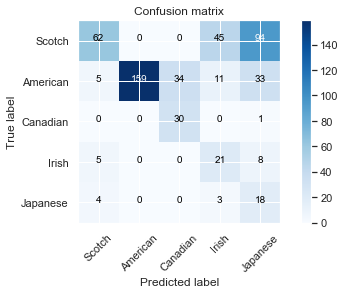

In [414]:
score_model(naive_bayes_model, "SMOTE Tomek", balanced['X_train'], balanced['y_train'], split['X_test'], split['y_test'])

In [415]:
summary_df

,Model,Imbalance Handling,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,LogisticRegression,None,0.760,0.702,0.760,0.729,0.809
1,KNeighborsClassifier,None,0.848,0.846,0.848,0.847,0.894
2,KNeighborsClassifier,None,0.867,0.853,0.867,0.853,0.898
3,DecisionTreeClassifier,None,0.775,0.702,0.775,0.736,0.813
4,DecisionTreeClassifier,None,0.807,0.728,0.807,0.764,0.839
...,...,...,...,...,...,...,...
93,GradientBoostingClassifier,SMOTE Tomek,0.614,0.834,0.614,0.669,0.776
94,GradientBoostingClassifier,SMOTE Tomek,0.867,0.862,0.867,0.864,0.906
95,XGBClassifier,SMOTE Tomek,0.829,0.838,0.829,0.833,0.884
96,XGBClassifier,SMOTE Tomek,0.852,0.851,0.852,0.850,0.895


In [416]:
summary_df.to_csv("results_summary.csv")

**Note:** Please proceed to the suceeding notebook for final model evaluation and selection.